<a href="https://www.mbd.rwth-aachen.de/">
    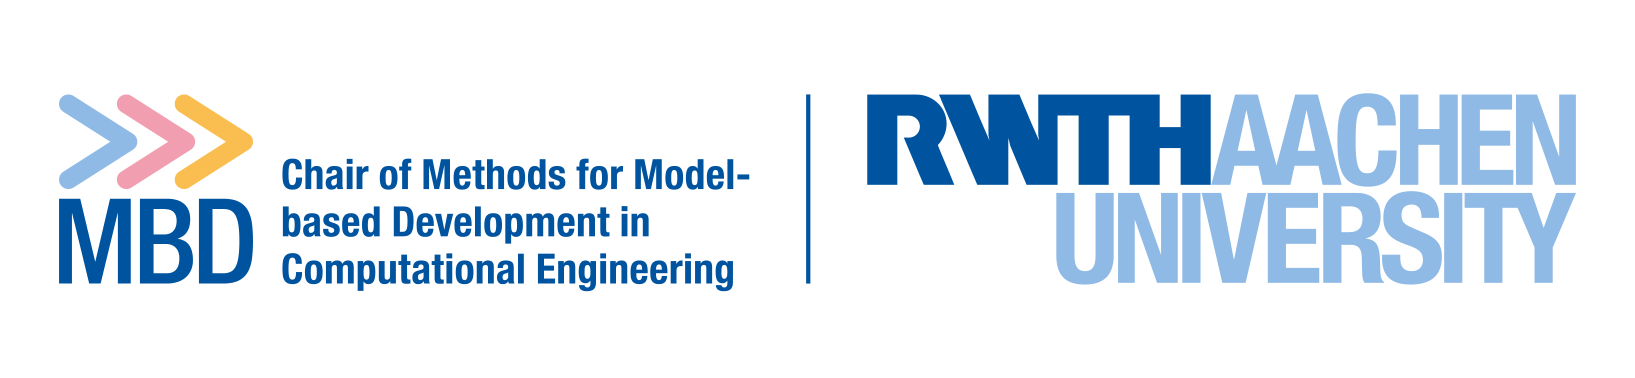
</a>
<a href="https://www.cpbl.rwth-aachen.de/">
    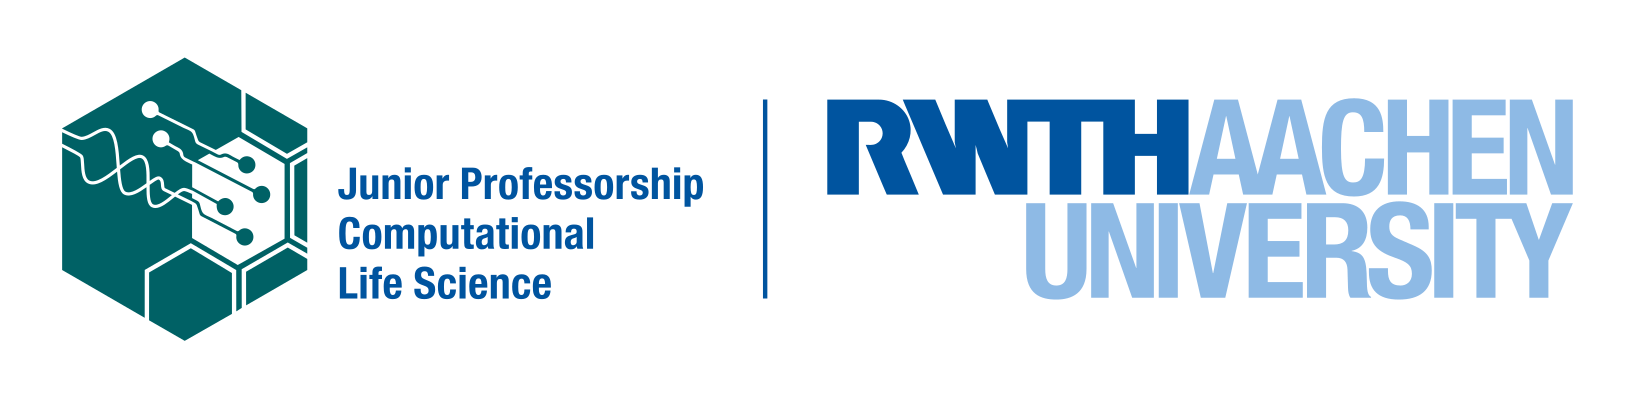
</a>

# Societal Challenges Datathon

Name: Vasu Hiteshi

Student number (Matrikelnummer): 484579


##  Note on File Structure

This file contains both **practice/work done during the course** and the **final working pipeline**.

- The initial sections include:
  - concept notes (markdown)
  - trial code / experiments
  - intermediate approaches tested during learning

- The **FINAL EXAM-READY PIPELINE** is present in the **last section** of this file and is the only part intended to be used for the final submission/exam.

 To directly use the final solution, scroll to the bottom and start from:  
**"FINAL EXAM PIPELINE"**

Cleaning the "Smoking data" by removing empty columns, adjusting negative values according to the variable and adjusting empty row values.

In [6]:
import pandas as pd
import numpy as np

# Read the CSV file
df = pd.read_csv('data/smoking_household_smokers.csv')

# Get the column names
first_col = 'NumberOfPeopleSmokingInHome'
second_col = 'NumberOfPeopleSmokingInsideHome'

# Process the first column
# Convert to numeric, handling empty values
df[first_col] = pd.to_numeric(df[first_col], errors='coerce')

# Fill empty values with 0
df[first_col] = df[first_col].fillna(0)

# If value is very small (less than 0.5), make it 0
df[first_col] = df[first_col].apply(lambda x: 0 if x < 0.5 else x)

# Convert to integer
df[first_col] = df[first_col].astype(int)

# If first column is now zero, make the second column 0 too
df.loc[df[first_col] == 0, second_col] = 0

# Fill any remaining empty values in second column with 0
df[second_col] = pd.to_numeric(df[second_col], errors='coerce')
df[second_col] = df[second_col].fillna(0)
df[second_col] = df[second_col].astype(int)

# Save the processed CSV
df.to_csv('data/smoking_household_smokers.csv', index=False)

print("Processing complete!")
print(f"First column '{first_col}' statistics:")
print(df[first_col].describe())
print(f"\nSecond column '{second_col}' statistics:")
print(df[second_col].describe())

Processing complete!
First column 'NumberOfPeopleSmokingInHome' statistics:
count    11933.000000
mean         0.285595
std          0.582075
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          2.000000
Name: NumberOfPeopleSmokingInHome, dtype: float64

Second column 'NumberOfPeopleSmokingInsideHome' statistics:
count    11933.000000
mean         0.103662
std          0.377765
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          2.000000
Name: NumberOfPeopleSmokingInsideHome, dtype: float64


Cleaning of smoking_recent_tobacco_use



In [7]:
import pandas as pd
import numpy as np

# Read the CSV file
df = pd.read_csv('data/smoking_recent_tobacco_use.csv')

print("Original data shape:", df.shape)
print("\nOriginal data types:")
print(df.dtypes)

# Convert all columns to numeric first, handling empty values
for col in df.columns:
    if col != 'sequence_no':
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Helper function to clean Yes/No columns (1 = Yes, 2 = No)
def clean_yes_no(value):
    if pd.isna(value):
        return np.nan
    val = float(value)
    if abs(val) < 0.5:
        return np.nan
    val_int = int(round(val))
    if val_int in [1, 2]:
        return val_int
    else:
        return np.nan

# Helper function to clean days columns (0-5)
def clean_days_0_5(value):
    if pd.isna(value):
        return np.nan
    val = float(value)
    if abs(val) < 0.5:
        return 0
    val_int = int(round(val))
    if 0 <= val_int <= 5:
        return val_int
    else:
        return np.nan

# Helper function to clean continuous values (reasonable range)
def clean_continuous(value, min_val=0, max_val=100):
    if pd.isna(value):
        return np.nan
    val = float(value)
    if abs(val) < 0.5:
        return 0
    val_int = int(round(val))
    if min_val <= val_int <= max_val:
        return val_int
    else:
        return np.nan

# Clean columns based on codebook specifications
# Yes/No columns (1 = Yes, 2 = No)
yes_no_cols = [
    'TabaccoProduct_5Days',
    'UsedECigarettes_5Days',
    'UsedSmokelessTobacco_5Days',
    'UsedNicotineReplacement_5Days',
    'UsedAnyTobaccoProduct_5Days'
]

for col in yes_no_cols:
    if col in df.columns:
        df[col] = df[col].apply(clean_yes_no)

# Days columns (0-5)
days_cols = [
    'DaysSmokedCigarettes_5Days',
    'NumberOfDaysUsedECigarettes_5Days',
    'NumberOfDaysSmokedPipe_5Days',
    'NumberOfDaysSmokedRegularCigars_5Days',
    'NumberOfDaysSmokedWaterPipeHookah_5Days'
]

for col in days_cols:
    if col in df.columns:
        df[col] = df[col].apply(clean_days_0_5)

# Continuous columns
if 'CigarettesSmokedPerSmokingDay_5Days' in df.columns:
    df['CigarettesSmokedPerSmokingDay_5Days'] = df['CigarettesSmokedPerSmokingDay_5Days'].apply(
        lambda x: clean_continuous(x, min_val=0, max_val=100)
    )

# ProductsUsed columns - typically categorical (1, 2, etc.), treat as Yes/No or small integers
products_cols = [col for col in df.columns if col.startswith('ProductsUsed_')]
for col in products_cols:
    if col in df.columns:
        df[col] = df[col].apply(clean_yes_no)

# LastCigaretteSmoked - likely categorical, treat as small integer (1-10 range)
if 'LastCigaretteSmoked' in df.columns:
    df['LastCigaretteSmoked'] = df['LastCigaretteSmoked'].apply(
        lambda x: clean_continuous(x, min_val=1, max_val=10) if not pd.isna(x) else np.nan
    )

# Convert sequence_no to integer
df['sequence_no'] = pd.to_numeric(df['sequence_no'], errors='coerce')
df['sequence_no'] = df['sequence_no'].fillna(0).astype(int)

# Convert all other columns to nullable integer type (Int64)
for col in df.columns:
    if col != 'sequence_no':
        df[col] = df[col].astype('Int64')

print("\n" + "="*50)
print("After cleaning smoking_recent_tobacco_use.csv:")
print("="*50)
print("\nData types after cleaning:")
print(df.dtypes)
print("\nSample of cleaned data:")
print(df.head(10))

# Save the cleaned CSV
df.to_csv('data/smoking_recent_tobacco_use.csv', index=False)
print("\nCleaned data saved to 'data/smoking_recent_tobacco_use.csv'")


Original data shape: (7199, 10)

Original data types:
sequence_no                              int64
TabaccoProduct_5Days                   float64
ProductsUsed_1                         float64
DaysSmokedCigarettes_5Days             float64
CigarettesSmokedPerSmokingDay_5Days    float64
LastCigaretteSmoked                    float64
UsedECigarettes_5Days                  float64
UsedSmokelessTobacco_5Days             float64
UsedNicotineReplacement_5Days          float64
UsedAnyTobaccoProduct_5Days            float64
dtype: object

After cleaning smoking_recent_tobacco_use.csv:

Data types after cleaning:
sequence_no                            int64
TabaccoProduct_5Days                   Int64
ProductsUsed_1                         Int64
DaysSmokedCigarettes_5Days             Int64
CigarettesSmokedPerSmokingDay_5Days    Int64
LastCigaretteSmoked                    Int64
UsedECigarettes_5Days                  Int64
UsedSmokelessTobacco_5Days             Int64
UsedNicotineReplacement_5D

Diabetes file cleaning



In [8]:
import pandas as pd
import numpy as np

# Read the CSV file
df = pd.read_csv('data/diabetes.csv')

print("Original data shape:", df.shape)
print("\nOriginal columns:", df.columns.tolist())
print("\nOriginal data types:")
print(df.dtypes)

# Check for empty column names and rename them
empty_cols = [i for i, col in enumerate(df.columns) if col == '' or pd.isna(col)]
if empty_cols:
    print(f"\nFound {len(empty_cols)} empty column name(s) at index(es): {empty_cols}")
    # Rename empty columns
    for idx in empty_cols:
        df.columns.values[idx] = f'Unnamed_{idx}'

# Convert all columns to numeric first, handling empty values
for col in df.columns:
    if col != 'sequence_no':
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Helper function to clean Yes/No columns (1 = Yes, 2 = No)
def clean_yes_no(value):
    if pd.isna(value):
        return np.nan
    val = float(value)
    if abs(val) < 0.5:
        return np.nan
    val_int = int(round(val))
    if val_int in [1, 2]:
        return val_int
    else:
        return np.nan

# Helper function to clean EverTold_Diabetes (1 = Yes, 2 = No, 3 = Borderline/Prediabetes)
def clean_ever_told_diabetes(value):
    if pd.isna(value):
        return np.nan
    val = float(value)
    if abs(val) < 0.5:
        return np.nan
    val_int = int(round(val))
    if val_int in [1, 2, 3]:
        return val_int
    else:
        return np.nan

# Helper function to clean BloodSugarTest_Last3Years (1 = Yes, 2 = No, 9 = Don't know)
def clean_blood_sugar_test(value):
    if pd.isna(value):
        return np.nan
    val = float(value)
    if abs(val) < 0.5:
        return np.nan
    val_int = int(round(val))
    if val_int in [1, 2, 9]:
        return val_int
    else:
        return np.nan

# Helper function to clean age (reasonable range 0-100)
def clean_age(value):
    if pd.isna(value):
        return np.nan
    val = float(value)
    if abs(val) < 0.5:
        return np.nan
    val_int = int(round(val))
    if 0 <= val_int <= 100:
        return val_int
    else:
        return np.nan

# Helper function to clean duration (reasonable range 0-100 years)
def clean_duration(value):
    if pd.isna(value):
        return np.nan
    val = float(value)
    if abs(val) < 0.5:
        return 0
    val_int = int(round(val))
    if 0 <= val_int <= 100:
        return val_int
    else:
        return np.nan

# Clean EverTold_Diabetes (1, 2, or 3)
if 'EverTold_Diabetes' in df.columns:
    df['EverTold_Diabetes'] = df['EverTold_Diabetes'].apply(clean_ever_told_diabetes)

# Clean Age_DiabetesDiagnosis (continuous age)
if 'Age_DiabetesDiagnosis' in df.columns:
    df['Age_DiabetesDiagnosis'] = df['Age_DiabetesDiagnosis'].apply(clean_age)

# Clean EverTold_Prediabetes (1 = Yes, 2 = No)
if 'EverTold_Prediabetes' in df.columns:
    df['EverTold_Prediabetes'] = df['EverTold_Prediabetes'].apply(clean_yes_no)

# Clean BloodSugarTest_Last3Years (1, 2, or 9)
if 'BloodSugarTest_Last3Years' in df.columns:
    df['BloodSugarTest_Last3Years'] = df['BloodSugarTest_Last3Years'].apply(clean_blood_sugar_test)

# Clean CurrentlyTaking_Insulin (1 = Yes, 2 = No)
if 'CurrentlyTaking_Insulin' in df.columns:
    df['CurrentlyTaking_Insulin'] = df['CurrentlyTaking_Insulin'].apply(clean_yes_no)

# Clean InsulinDuration (continuous duration)
if 'InsulinDuration' in df.columns:
    df['InsulinDuration'] = df['InsulinDuration'].apply(clean_duration)

# Clean CurrentlyTaking_DiabeticPills (1 = Yes, 2 = No)
if 'CurrentlyTaking_DiabeticPills' in df.columns:
    df['CurrentlyTaking_DiabeticPills'] = df['CurrentlyTaking_DiabeticPills'].apply(clean_yes_no)

# Convert sequence_no to integer
df['sequence_no'] = pd.to_numeric(df['sequence_no'], errors='coerce')
df['sequence_no'] = df['sequence_no'].fillna(0).astype(int)

# Convert all other columns to nullable integer type (Int64)
for col in df.columns:
    if col != 'sequence_no':
        df[col] = df[col].astype('Int64')

print("\n" + "="*50)
print("After cleaning diabetes.csv:")
print("="*50)
print("\nData types after cleaning:")
print(df.dtypes)
print("\nUnique values in EverTold_Diabetes:")
print(df['EverTold_Diabetes'].value_counts(dropna=False))
print("\nUnique values in BloodSugarTest_Last3Years:")
print(df['BloodSugarTest_Last3Years'].value_counts(dropna=False))
print("\nSample of cleaned data:")
print(df.head(10))

# Save the cleaned CSV
df.to_csv('data/diabetes.csv', index=False)
print("\nCleaned data saved to 'data/diabetes.csv'")


Original data shape: (11744, 5)

Original columns: ['sequence_no', 'EverTold_Diabetes', 'EverTold_Prediabetes', 'BloodSugarTest_Last3Years', 'CurrentlyTaking_DiabeticPills']

Original data types:
sequence_no                        int64
EverTold_Diabetes                float64
EverTold_Prediabetes             float64
BloodSugarTest_Last3Years        float64
CurrentlyTaking_DiabeticPills    float64
dtype: object

After cleaning diabetes.csv:

Data types after cleaning:
sequence_no                      int64
EverTold_Diabetes                Int64
EverTold_Prediabetes             Int64
BloodSugarTest_Last3Years        Int64
CurrentlyTaking_DiabeticPills    Int64
dtype: object

Unique values in EverTold_Diabetes:
EverTold_Diabetes
2       10371
1        1081
3         284
<NA>        8
Name: count, dtype: Int64

Unique values in BloodSugarTest_Last3Years:
BloodSugarTest_Last3Years
2       4667
<NA>    3707
1       3370
Name: count, dtype: Int64

Sample of cleaned data:
   sequence_no  Ever

In [10]:
# EDA 1: Load and merge all datasets
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Load datasets
diabetes_df = pd.read_csv('data/diabetes.csv')
smoking_cigarette_df = pd.read_csv('data/smoking_cigarette_use.csv')
smoking_household_df = pd.read_csv('data/smoking_household_smokers.csv')
smoking_recent_df = pd.read_csv('data/smoking_recent_tobacco_use.csv')

# Merge all datasets on sequence_no
df = diabetes_df.merge(smoking_cigarette_df, on='sequence_no', how='outer', suffixes=('', '_cig'))
df = df.merge(smoking_household_df, on='sequence_no', how='outer', suffixes=('', '_house'))
df = df.merge(smoking_recent_df, on='sequence_no', how='outer', suffixes=('', '_recent'))

print("Merged dataset shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nFirst few rows:")
df.head()


Merged dataset shape: (11933, 20)

Columns: ['sequence_no', 'EverTold_Diabetes', 'EverTold_Prediabetes', 'BloodSugarTest_Last3Years', 'CurrentlyTaking_DiabeticPills', 'SmokedAtLeast100CigarettesInLife', 'CurrentCigaretteSmoking', 'CigarettesPerDayOnSmokingDays_30Days', 'QuestionnaireModeFlag', 'NumberOfPeopleSmokingInHome', 'NumberOfPeopleSmokingInsideHome', 'TabaccoProduct_5Days', 'ProductsUsed_1', 'DaysSmokedCigarettes_5Days', 'CigarettesSmokedPerSmokingDay_5Days', 'LastCigaretteSmoked', 'UsedECigarettes_5Days', 'UsedSmokelessTobacco_5Days', 'UsedNicotineReplacement_5Days', 'UsedAnyTobaccoProduct_5Days']

First few rows:


,sequence_no,EverTold_Diabetes,EverTold_Prediabetes,BloodSugarTest_Last3Years,CurrentlyTaking_DiabeticPills,SmokedAtLeast100CigarettesInLife,CurrentCigaretteSmoking,CigarettesPerDayOnSmokingDays_30Days,QuestionnaireModeFlag,NumberOfPeopleSmokingInHome,NumberOfPeopleSmokingInsideHome,TabaccoProduct_5Days,ProductsUsed_1,DaysSmokedCigarettes_5Days,CigarettesSmokedPerSmokingDay_5Days,LastCigaretteSmoked,UsedECigarettes_5Days,UsedSmokelessTobacco_5Days,UsedNicotineReplacement_5Days,UsedAnyTobaccoProduct_5Days
0,130378,2.0,2.0,2.0,NaN,1.0,3.0,NaN,1.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,130379,2.0,2.0,1.0,NaN,1.0,3.0,NaN,1.0,0,0,2.0,NaN,NaN,NaN,NaN,2.0,2.0,2.0,2.0
2,130380,1.0,NaN,NaN,1.0,2.0,NaN,NaN,1.0,0,0,2.0,NaN,NaN,NaN,NaN,2.0,2.0,2.0,2.0
3,130381,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,130382,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


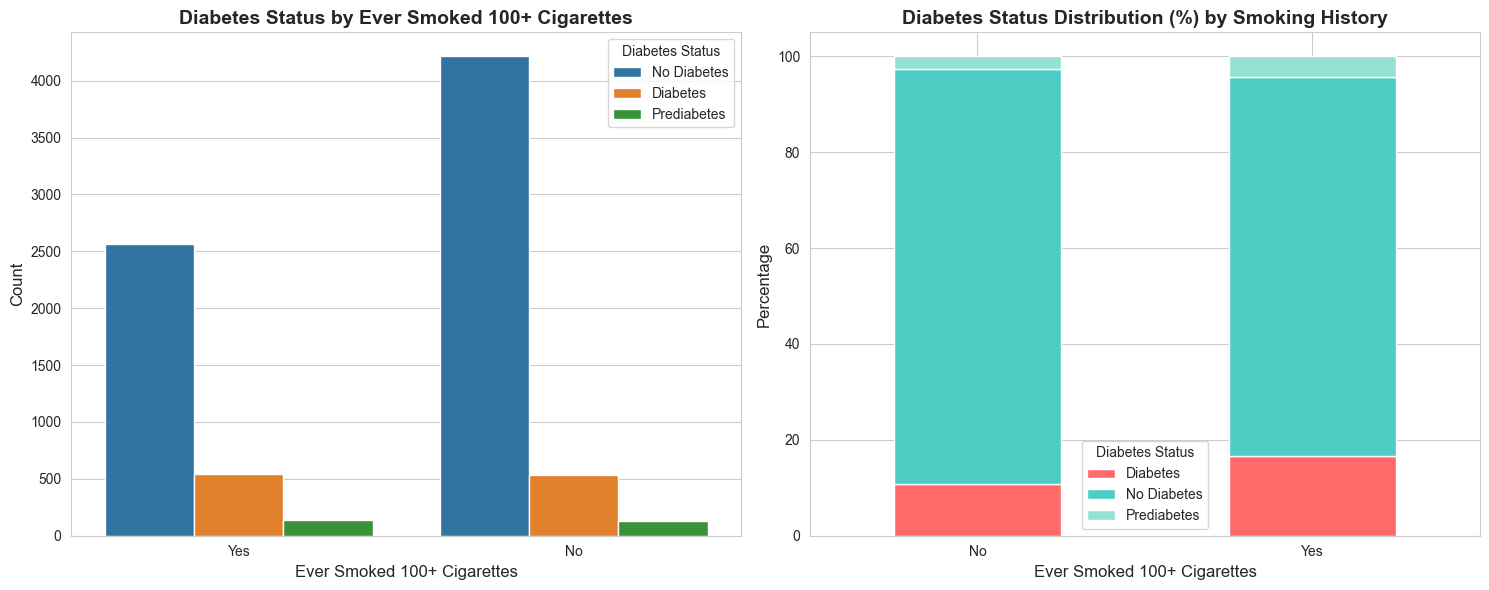


Diabetes Prevalence by Smoking History:
Diabetes_Status  Diabetes  No Diabetes  Prediabetes   All
Ever_Smoked_100                                          
No                    529         4215          133  4877
Yes                   541         2562          139  3242
All                  1070         6777          272  8119

Percentage breakdown:
Diabetes_Status   Diabetes  No Diabetes  Prediabetes
Ever_Smoked_100                                     
No               10.846832    86.426082     2.727086
Yes              16.687230    79.025293     4.287477


In [ ]:
# EDA 1: Diabetes Prevalence by Smoking Status (Ever Smoked 100+ Cigarettes)
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Create diabetes status column (combining diabetes and prediabetes)
df['Diabetes_Status'] = df['EverTold_Diabetes'].map({1: 'Diabetes', 2: 'No Diabetes', 3: 'Prediabetes'})
df['Ever_Smoked_100'] = df['SmokedAtLeast100CigarettesInLife'].map({1: 'Yes', 2: 'No'})

# Plot 1: Count plot
sns.countplot(data=df, x='Ever_Smoked_100', hue='Diabetes_Status', ax=axes[0])
axes[0].set_title('Diabetes Status by Ever Smoked 100+ Cigarettes', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Ever Smoked 100+ Cigarettes', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].legend(title='Diabetes Status')

# Plot 2: Percentage stacked bar
diab_smoke_cross = pd.crosstab(df['Ever_Smoked_100'], df['Diabetes_Status'], normalize='index') * 100
diab_smoke_cross.plot(kind='bar', stacked=True, ax=axes[1], color=['#ff6b6b', '#4ecdc4', '#95e1d3'])
axes[1].set_title('Diabetes Status Distribution (%) by Smoking History', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Ever Smoked 100+ Cigarettes', fontsize=12)
axes[1].set_ylabel('Percentage', fontsize=12)
axes[1].legend(title='Diabetes Status')
axes[1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

# Calculate statistics
print("\n" + "="*60)
print("Diabetes Prevalence by Smoking History:")
print("="*60)
diab_smoke_stats = pd.crosstab(df['Ever_Smoked_100'], df['Diabetes_Status'], margins=True)
print(diab_smoke_stats)
print("\nPercentage breakdown:")
print(pd.crosstab(df['Ever_Smoked_100'], df['Diabetes_Status'], normalize='index') * 100)


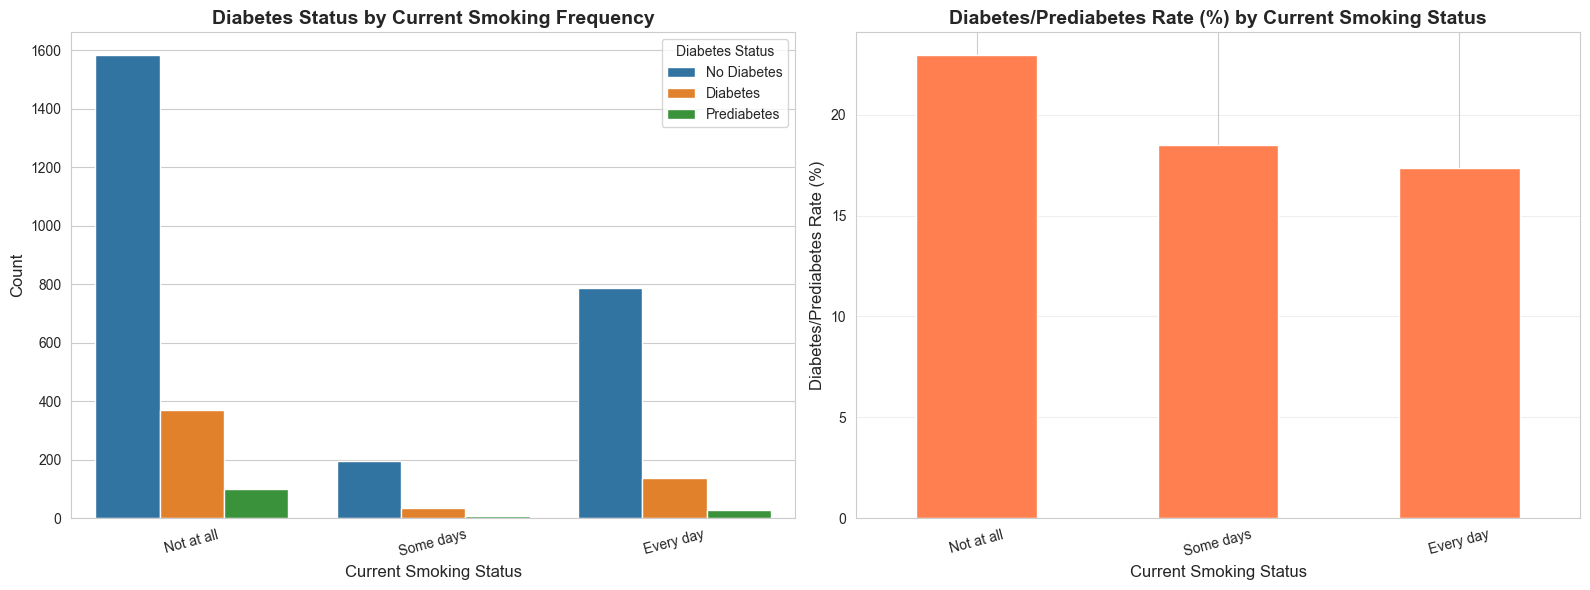


Diabetes Status by Current Smoking:
Diabetes_Status   Diabetes  No Diabetes  Prediabetes
Current_Smoking                                     
Every day        14.300736    82.649842     3.049422
Not at all       18.022406    77.057964     4.919630
Some days        14.705882    81.512605     3.781513

Diabetes/Prediabetes Rate by Smoking Status:
Not at all: 22.94%
Some days: 18.49%
Every day: 17.35%


In [ ]:
# EDA 2: Current Smoking Status vs Diabetes
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Create current smoking status
df['Current_Smoking'] = df['CurrentCigaretteSmoking'].map({
    1: 'Every day', 
    2: 'Some days', 
    3: 'Not at all'
})

# Filter out missing values
df_clean = df.dropna(subset=['Current_Smoking', 'Diabetes_Status'])

# Plot 1: Count plot
sns.countplot(data=df_clean, x='Current_Smoking', hue='Diabetes_Status', ax=axes[0], 
              order=['Not at all', 'Some days', 'Every day'])
axes[0].set_title('Diabetes Status by Current Smoking Frequency', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Current Smoking Status', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].legend(title='Diabetes Status')
axes[0].tick_params(axis='x', rotation=15)

# Plot 2: Diabetes rate by smoking status
diab_by_smoking = df_clean.groupby('Current_Smoking')['Diabetes_Status'].apply(
    lambda x: (x.isin(['Diabetes', 'Prediabetes']).sum() / len(x) * 100)
).sort_values(ascending=False)

diab_by_smoking.plot(kind='bar', ax=axes[1], color='coral')
axes[1].set_title('Diabetes/Prediabetes Rate (%) by Current Smoking Status', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Current Smoking Status', fontsize=12)
axes[1].set_ylabel('Diabetes/Prediabetes Rate (%)', fontsize=12)
axes[1].tick_params(axis='x', rotation=15)
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Statistics
print("\n" + "="*60)
print("Diabetes Status by Current Smoking:")
print("="*60)
print(pd.crosstab(df_clean['Current_Smoking'], df_clean['Diabetes_Status'], normalize='index') * 100)
print("\nDiabetes/Prediabetes Rate by Smoking Status:")
for status, rate in diab_by_smoking.items():
    print(f"{status}: {rate:.2f}%")


/var/folders/zp/gfdyts9j4vjcl4h612wybgcc0000gn/T/ipykernel_62661/2750578199.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  diab_by_household = df_household.groupby('Household_Smokers_Category')['Diabetes_Status'].apply(


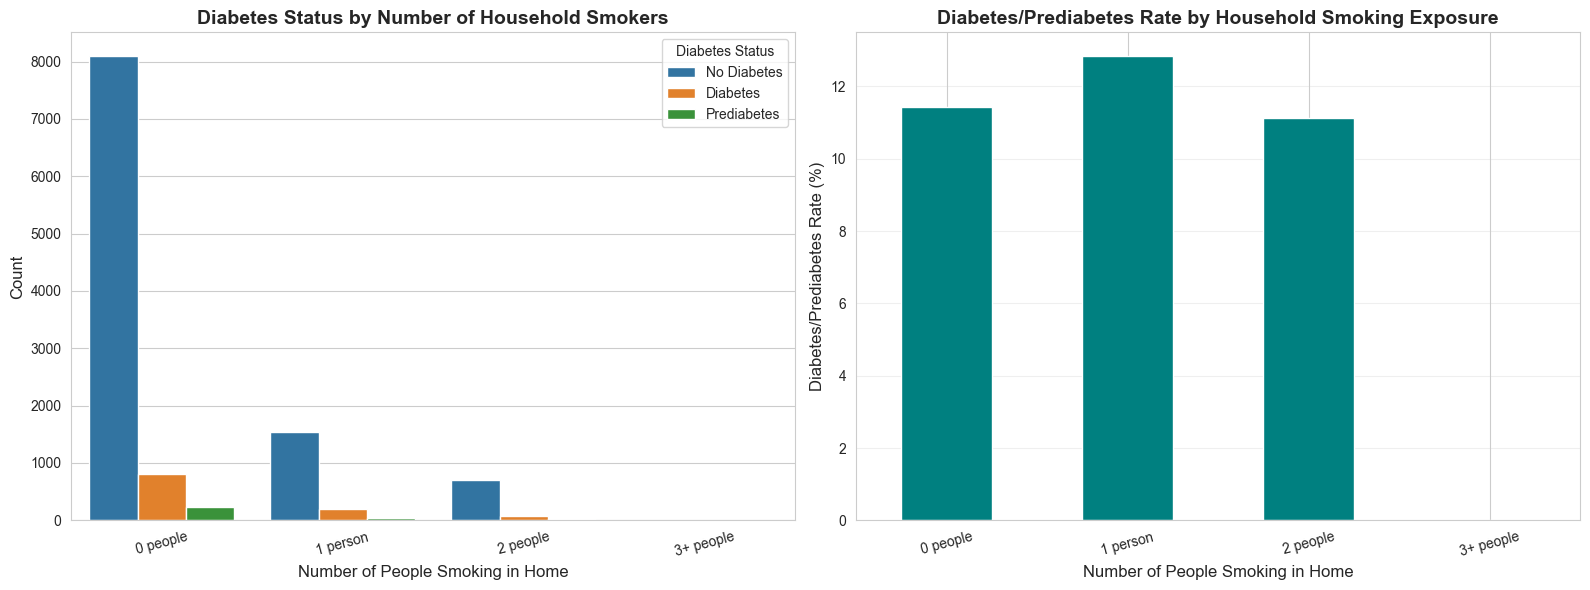


Diabetes Rate by Household Smoking Exposure:
0 people: 11.42% (n=9149)
1 person: 12.85% (n=1774)
2 people: 11.13% (n=791)
3+ people: 0.00% (n=0)


In [ ]:
# EDA 3: Household Smoking Exposure vs Diabetes
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Create household smoking exposure categories
df['Household_Smokers'] = df['NumberOfPeopleSmokingInHome']
df['Household_Smokers_Category'] = pd.cut(
    df['Household_Smokers'].fillna(0),
    bins=[-1, 0, 1, 2, 10],
    labels=['0 people', '1 person', '2 people', '3+ people']
)

df_household = df[df['Household_Smokers_Category'].notna() & df['Diabetes_Status'].notna()].copy()

# Plot 1: Count plot
sns.countplot(data=df_household, x='Household_Smokers_Category', hue='Diabetes_Status', ax=axes[0])
axes[0].set_title('Diabetes Status by Number of Household Smokers', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Number of People Smoking in Home', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].legend(title='Diabetes Status')
axes[0].tick_params(axis='x', rotation=15)

# Plot 2: Diabetes rate by household smokers
diab_by_household = df_household.groupby('Household_Smokers_Category')['Diabetes_Status'].apply(
    lambda x: (x.isin(['Diabetes', 'Prediabetes']).sum() / len(x) * 100) if len(x) > 0 else 0
)

diab_by_household.plot(kind='bar', ax=axes[1], color='teal')
axes[1].set_title('Diabetes/Prediabetes Rate by Household Smoking Exposure', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Number of People Smoking in Home', fontsize=12)
axes[1].set_ylabel('Diabetes/Prediabetes Rate (%)', fontsize=12)
axes[1].tick_params(axis='x', rotation=15)
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Statistics
print("\n" + "="*60)
print("Diabetes Rate by Household Smoking Exposure:")
print("="*60)
for category, rate in diab_by_household.items():
    count = len(df_household[df_household['Household_Smokers_Category'] == category])
    print(f"{category}: {rate:.2f}% (n={count})")


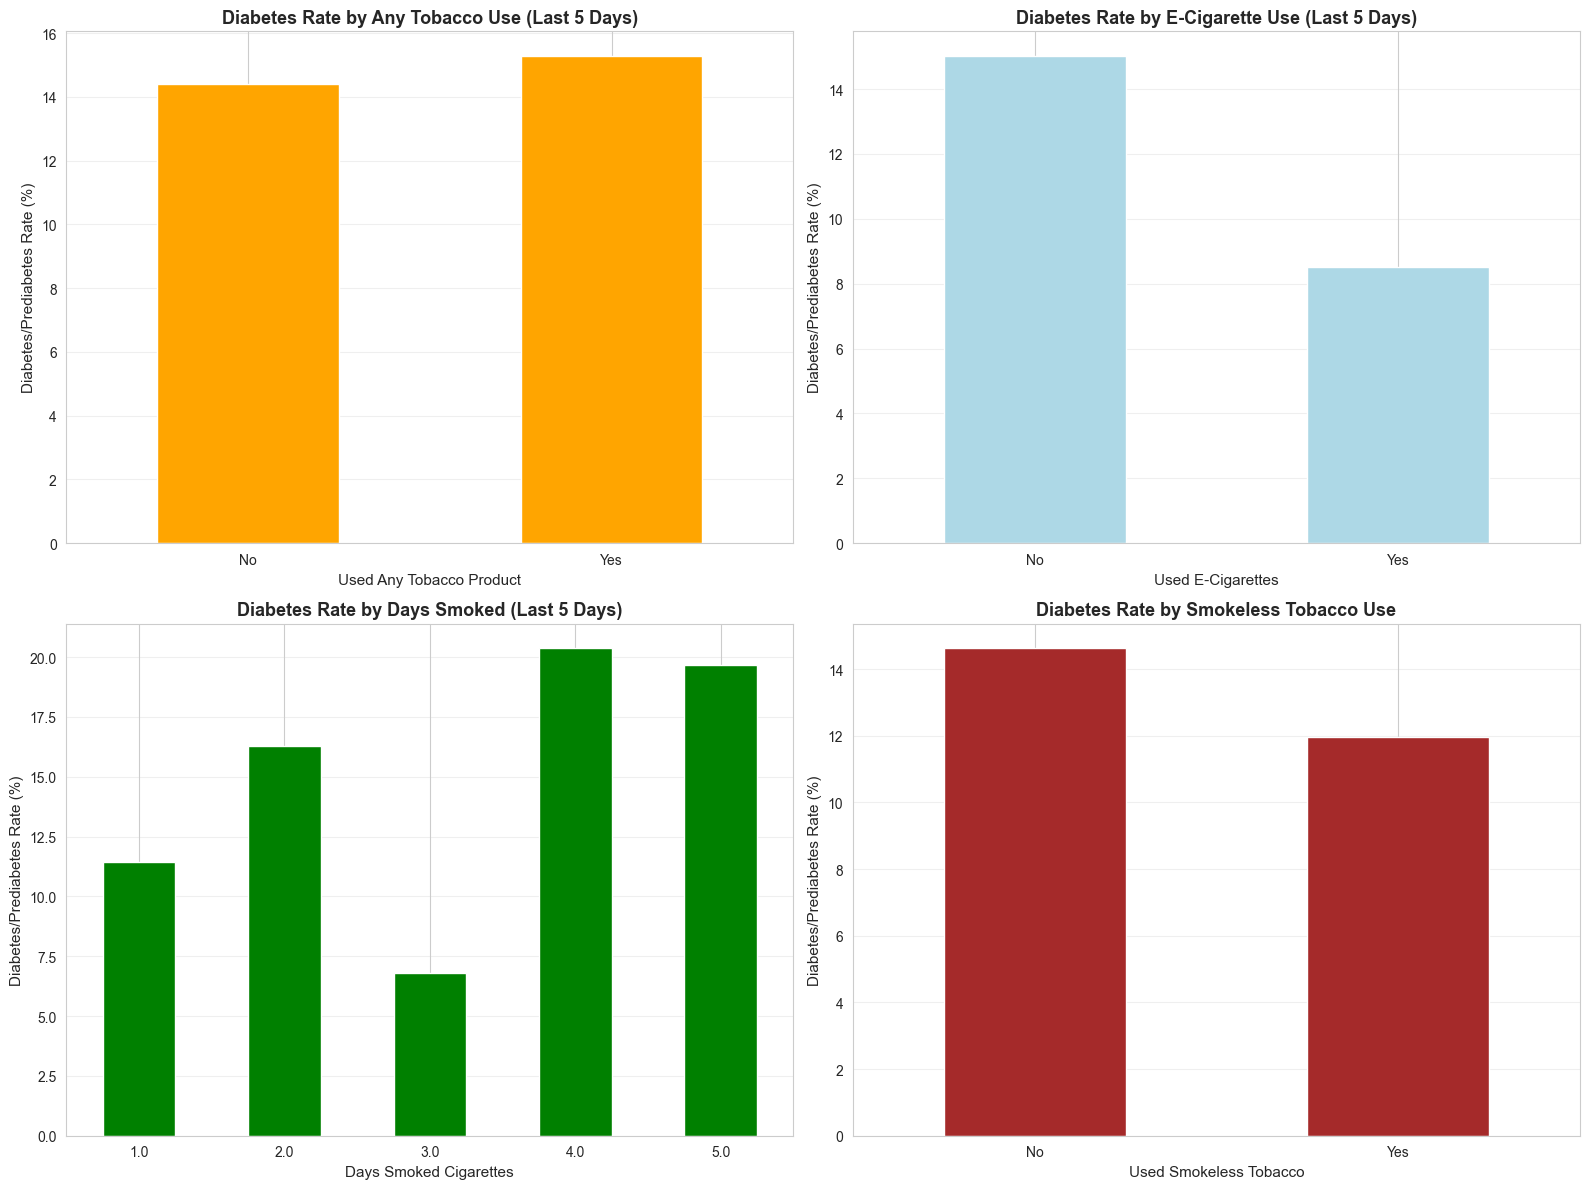


Recent Tobacco Use (Last 5 Days) vs Diabetes:

Any Tobacco Use:
  No: 14.41% (n=4968)
  Yes: 15.29% (n=1282)


In [ ]:
# EDA 4: Recent Tobacco Use (Last 5 Days) vs Diabetes
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Create recent tobacco use indicators
df['Used_Any_Tobacco_5Days'] = df['UsedAnyTobaccoProduct_5Days'].map({1: 'Yes', 2: 'No'})
df['Used_E_Cigarettes_5Days'] = df['UsedECigarettes_5Days'].map({1: 'Yes', 2: 'No'})
df['Used_Smokeless_Tobacco_5Days'] = df['UsedSmokelessTobacco_5Days'].map({1: 'Yes', 2: 'No'})

# Filter for valid data
df_recent = df[df['Used_Any_Tobacco_5Days'].notna() & df['Diabetes_Status'].notna()].copy()

# Plot 1: Any tobacco use in last 5 days
if len(df_recent) > 0:
    diab_by_any_tobacco = df_recent.groupby('Used_Any_Tobacco_5Days')['Diabetes_Status'].apply(
        lambda x: (x.isin(['Diabetes', 'Prediabetes']).sum() / len(x) * 100) if len(x) > 0 else 0
    )
    diab_by_any_tobacco.plot(kind='bar', ax=axes[0,0], color='orange')
    axes[0,0].set_title('Diabetes Rate by Any Tobacco Use (Last 5 Days)', fontsize=13, fontweight='bold')
    axes[0,0].set_xlabel('Used Any Tobacco Product', fontsize=11)
    axes[0,0].set_ylabel('Diabetes/Prediabetes Rate (%)', fontsize=11)
    axes[0,0].tick_params(axis='x', rotation=0)
    axes[0,0].grid(axis='y', alpha=0.3)

# Plot 2: E-cigarette use
df_e_cig = df[df['Used_E_Cigarettes_5Days'].notna() & df['Diabetes_Status'].notna()].copy()
if len(df_e_cig) > 0:
    diab_by_ecig = df_e_cig.groupby('Used_E_Cigarettes_5Days')['Diabetes_Status'].apply(
        lambda x: (x.isin(['Diabetes', 'Prediabetes']).sum() / len(x) * 100) if len(x) > 0 else 0
    )
    diab_by_ecig.plot(kind='bar', ax=axes[0,1], color='lightblue')
    axes[0,1].set_title('Diabetes Rate by E-Cigarette Use (Last 5 Days)', fontsize=13, fontweight='bold')
    axes[0,1].set_xlabel('Used E-Cigarettes', fontsize=11)
    axes[0,1].set_ylabel('Diabetes/Prediabetes Rate (%)', fontsize=11)
    axes[0,1].tick_params(axis='x', rotation=0)
    axes[0,1].grid(axis='y', alpha=0.3)

# Plot 3: Days smoked cigarettes in last 5 days
df['Days_Smoked_5Days'] = df['DaysSmokedCigarettes_5Days']
df_days5 = df[df['Days_Smoked_5Days'].notna() & df['Diabetes_Status'].notna()].copy()
if len(df_days5) > 0:
    diab_by_days5 = df_days5.groupby('Days_Smoked_5Days')['Diabetes_Status'].apply(
        lambda x: (x.isin(['Diabetes', 'Prediabetes']).sum() / len(x) * 100) if len(x) > 0 else 0
    )
    diab_by_days5.plot(kind='bar', ax=axes[1,0], color='green')
    axes[1,0].set_title('Diabetes Rate by Days Smoked (Last 5 Days)', fontsize=13, fontweight='bold')
    axes[1,0].set_xlabel('Days Smoked Cigarettes', fontsize=11)
    axes[1,0].set_ylabel('Diabetes/Prediabetes Rate (%)', fontsize=11)
    axes[1,0].tick_params(axis='x', rotation=0)
    axes[1,0].grid(axis='y', alpha=0.3)

# Plot 4: Smokeless tobacco use
df_smokeless = df[df['Used_Smokeless_Tobacco_5Days'].notna() & df['Diabetes_Status'].notna()].copy()
if len(df_smokeless) > 0:
    diab_by_smokeless = df_smokeless.groupby('Used_Smokeless_Tobacco_5Days')['Diabetes_Status'].apply(
        lambda x: (x.isin(['Diabetes', 'Prediabetes']).sum() / len(x) * 100) if len(x) > 0 else 0
    )
    diab_by_smokeless.plot(kind='bar', ax=axes[1,1], color='brown')
    axes[1,1].set_title('Diabetes Rate by Smokeless Tobacco Use', fontsize=13, fontweight='bold')
    axes[1,1].set_xlabel('Used Smokeless Tobacco', fontsize=11)
    axes[1,1].set_ylabel('Diabetes/Prediabetes Rate (%)', fontsize=11)
    axes[1,1].tick_params(axis='x', rotation=0)
    axes[1,1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Statistics
print("\n" + "="*60)
print("Recent Tobacco Use (Last 5 Days) vs Diabetes:")
print("="*60)
if len(df_recent) > 0:
    print("\nAny Tobacco Use:")
    for use, rate in diab_by_any_tobacco.items():
        count = len(df_recent[df_recent['Used_Any_Tobacco_5Days'] == use])
        print(f"  {use}: {rate:.2f}% (n={count})")


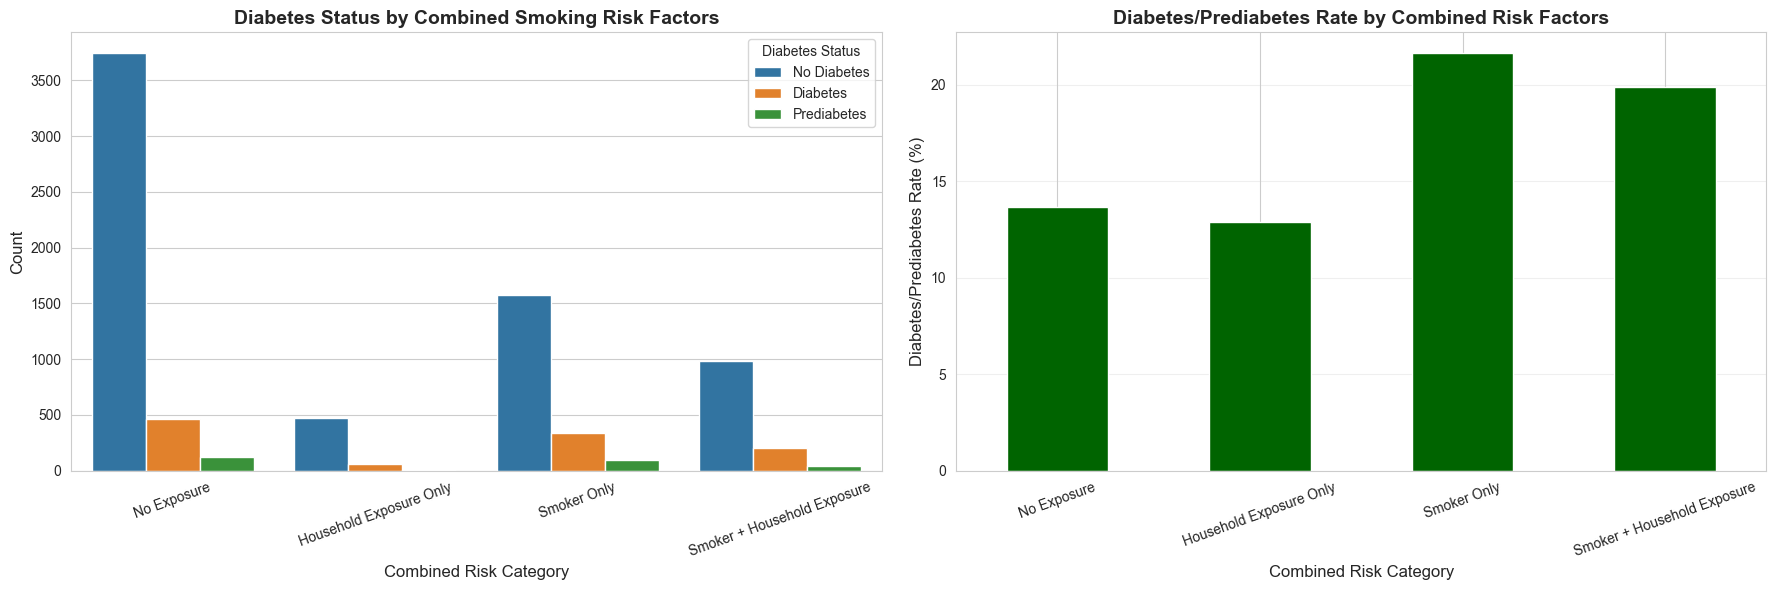


Diabetes Rate by Combined Risk Factors:
No Exposure: 13.66% (n=4335)
Household Exposure Only: 12.92% (n=542)
Smoker Only: 21.64% (n=2010)
Smoker + Household Exposure: 19.89% (n=1232)


In [ ]:
# EDA 5: Combined Risk Factors - Smoking Intensity + Household Exposure
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Create combined risk factor
df['Combined_Risk'] = 'Low Risk'
df.loc[(df['Ever_Smoked_100'] == 'Yes') & (df['Household_Smokers'] > 0), 'Combined_Risk'] = 'Smoker + Household Exposure'
df.loc[(df['Ever_Smoked_100'] == 'Yes') & (df['Household_Smokers'] == 0), 'Combined_Risk'] = 'Smoker Only'
df.loc[(df['Ever_Smoked_100'] == 'No') & (df['Household_Smokers'] > 0), 'Combined_Risk'] = 'Household Exposure Only'
df.loc[(df['Ever_Smoked_100'] == 'No') & (df['Household_Smokers'] == 0), 'Combined_Risk'] = 'No Exposure'

df_combined = df[df['Combined_Risk'].notna() & df['Diabetes_Status'].notna()].copy()

# Plot 1: Count plot
sns.countplot(data=df_combined, x='Combined_Risk', hue='Diabetes_Status', ax=axes[0],
              order=['No Exposure', 'Household Exposure Only', 'Smoker Only', 'Smoker + Household Exposure'])
axes[0].set_title('Diabetes Status by Combined Smoking Risk Factors', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Combined Risk Category', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].legend(title='Diabetes Status')
axes[0].tick_params(axis='x', rotation=20)

# Plot 2: Diabetes rate by combined risk
diab_by_combined = df_combined.groupby('Combined_Risk')['Diabetes_Status'].apply(
    lambda x: (x.isin(['Diabetes', 'Prediabetes']).sum() / len(x) * 100) if len(x) > 0 else 0
).reindex(['No Exposure', 'Household Exposure Only', 'Smoker Only', 'Smoker + Household Exposure'])

diab_by_combined.plot(kind='bar', ax=axes[1], color='darkgreen')
axes[1].set_title('Diabetes/Prediabetes Rate by Combined Risk Factors', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Combined Risk Category', fontsize=12)
axes[1].set_ylabel('Diabetes/Prediabetes Rate (%)', fontsize=12)
axes[1].tick_params(axis='x', rotation=20)
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Statistics
print("\n" + "="*60)
print("Diabetes Rate by Combined Risk Factors:")
print("="*60)
for risk, rate in diab_by_combined.items():
    count = len(df_combined[df_combined['Combined_Risk'] == risk])
    print(f"{risk}: {rate:.2f}% (n={count})")


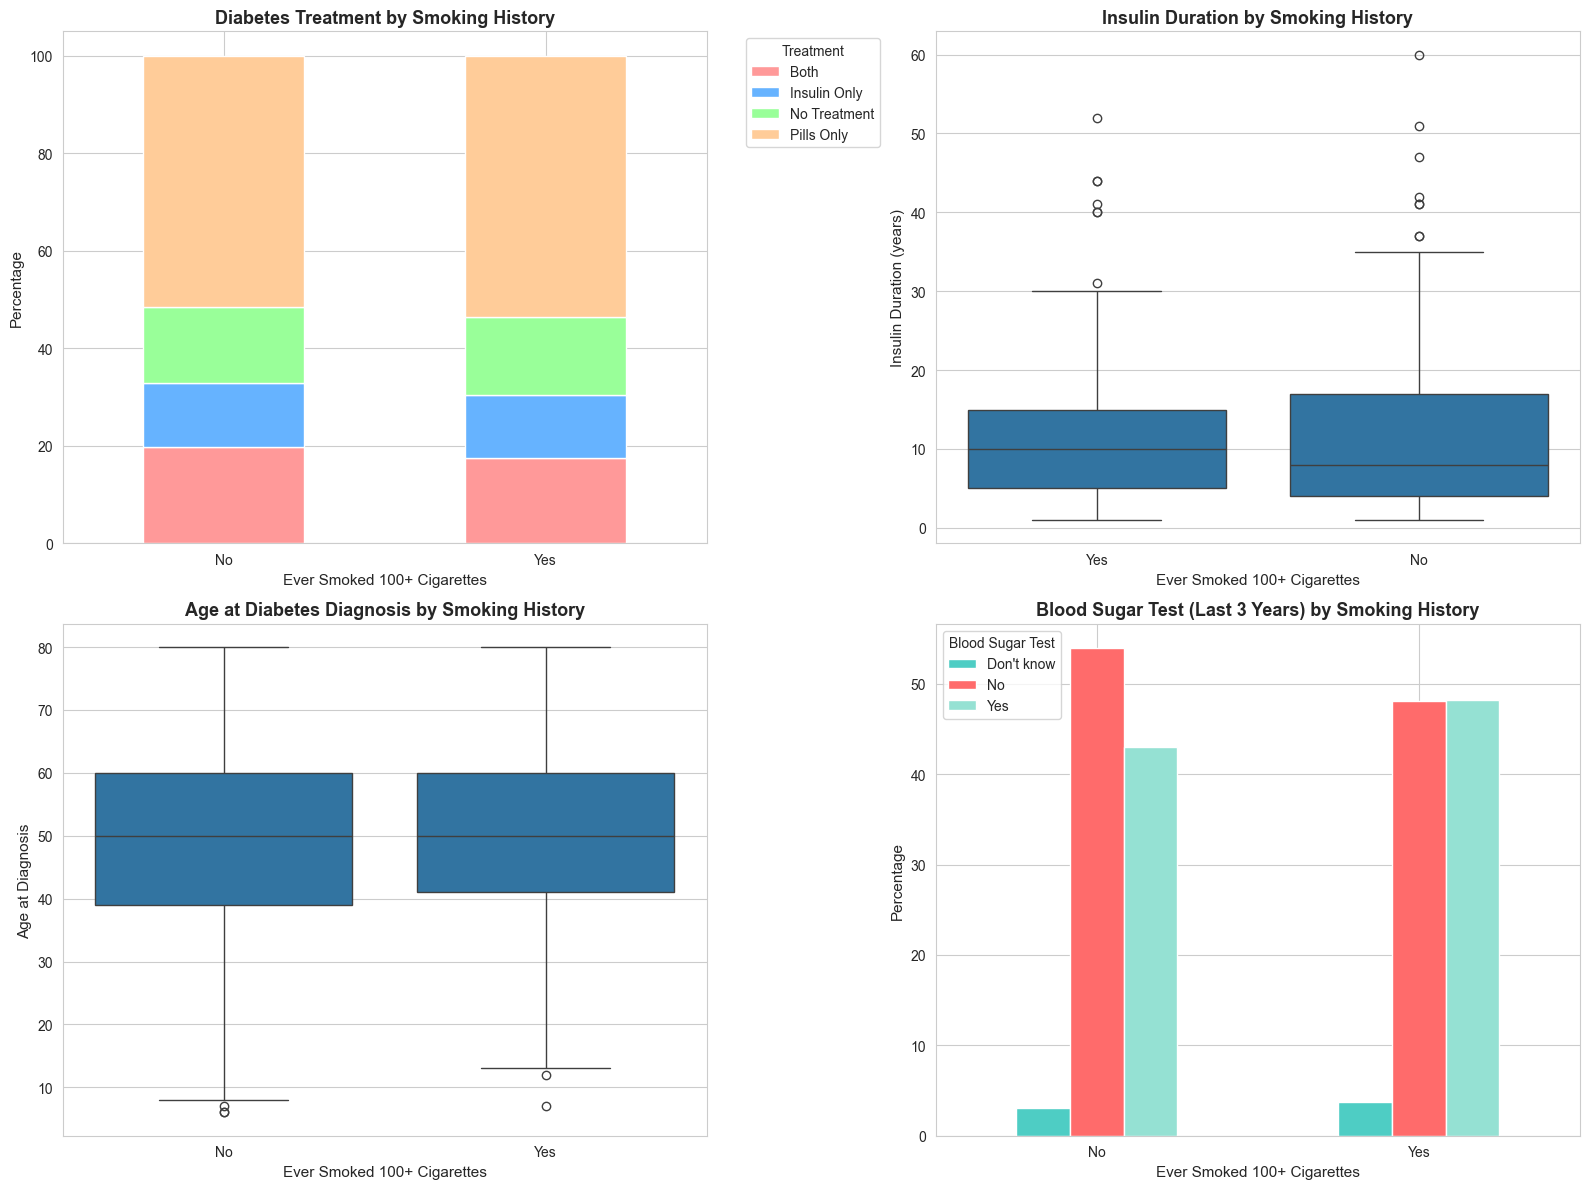


Diabetes Treatment by Smoking History:
Treatment_Status  Both  Insulin Only  No Treatment  Pills Only
Ever_Smoked_100                                               
No                 104            70            82         273
Yes                 95            70            86         290


In [ ]:
# EDA 6: Diabetes Treatment Status by Smoking History
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Create treatment indicators
df['Taking_Insulin'] = df['CurrentlyTaking_Insulin'].map({1: 'Yes', 2: 'No'})
df['Taking_Pills'] = df['CurrentlyTaking_DiabeticPills'].map({1: 'Yes', 2: 'No'})
df['Treatment_Status'] = 'No Treatment'
df.loc[(df['Taking_Insulin'] == 'Yes') & (df['Taking_Pills'] == 'Yes'), 'Treatment_Status'] = 'Both'
df.loc[(df['Taking_Insulin'] == 'Yes') & (df['Taking_Pills'] != 'Yes'), 'Treatment_Status'] = 'Insulin Only'
df.loc[(df['Taking_Insulin'] != 'Yes') & (df['Taking_Pills'] == 'Yes'), 'Treatment_Status'] = 'Pills Only'

# Filter for diabetics only
df_diabetics = df[df['EverTold_Diabetes'] == 1].copy()

# Plot 1: Treatment status by smoking history
df_diabetics_clean = df_diabetics[df_diabetics['Ever_Smoked_100'].notna() & 
                                   df_diabetics['Treatment_Status'].notna()].copy()
if len(df_diabetics_clean) > 0:
    treatment_by_smoking = pd.crosstab(df_diabetics_clean['Ever_Smoked_100'], 
                                        df_diabetics_clean['Treatment_Status'], 
                                        normalize='index') * 100
    treatment_by_smoking.plot(kind='bar', ax=axes[0,0], stacked=True, 
                              color=['#ff9999', '#66b3ff', '#99ff99', '#ffcc99'])
    axes[0,0].set_title('Diabetes Treatment by Smoking History', fontsize=13, fontweight='bold')
    axes[0,0].set_xlabel('Ever Smoked 100+ Cigarettes', fontsize=11)
    axes[0,0].set_ylabel('Percentage', fontsize=11)
    axes[0,0].legend(title='Treatment', bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[0,0].tick_params(axis='x', rotation=0)

# Plot 2: Insulin duration by smoking status
df_insulin = df_diabetics[(df_diabetics['Taking_Insulin'] == 'Yes') & 
                          (df_diabetics['InsulinDuration'].notna()) &
                          (df_diabetics['Ever_Smoked_100'].notna())].copy()
if len(df_insulin) > 0:
    sns.boxplot(data=df_insulin, x='Ever_Smoked_100', y='InsulinDuration', ax=axes[0,1])
    axes[0,1].set_title('Insulin Duration by Smoking History', fontsize=13, fontweight='bold')
    axes[0,1].set_xlabel('Ever Smoked 100+ Cigarettes', fontsize=11)
    axes[0,1].set_ylabel('Insulin Duration (years)', fontsize=11)
    axes[0,1].tick_params(axis='x', rotation=0)

# Plot 3: Age at diagnosis by smoking status
df_age_diag = df_diabetics[(df_diabetics['Age_DiabetesDiagnosis'].notna()) & 
                            (df_diabetics['Ever_Smoked_100'].notna())].copy()
if len(df_age_diag) > 0:
    sns.boxplot(data=df_age_diag, x='Ever_Smoked_100', y='Age_DiabetesDiagnosis', ax=axes[1,0])
    axes[1,0].set_title('Age at Diabetes Diagnosis by Smoking History', fontsize=13, fontweight='bold')
    axes[1,0].set_xlabel('Ever Smoked 100+ Cigarettes', fontsize=11)
    axes[1,0].set_ylabel('Age at Diagnosis', fontsize=11)
    axes[1,0].tick_params(axis='x', rotation=0)

# Plot 4: Blood sugar test by smoking status
df['Blood_Sugar_Test'] = df['BloodSugarTest_Last3Years'].map({1: 'Yes', 2: 'No', 9: "Don't know"})
df_test = df[df['Blood_Sugar_Test'].notna() & df['Ever_Smoked_100'].notna()].copy()
if len(df_test) > 0:
    test_by_smoking = pd.crosstab(df_test['Ever_Smoked_100'], df_test['Blood_Sugar_Test'], normalize='index') * 100
    test_by_smoking.plot(kind='bar', ax=axes[1,1], color=['#4ecdc4', '#ff6b6b', '#95e1d3'])
    axes[1,1].set_title('Blood Sugar Test (Last 3 Years) by Smoking History', fontsize=13, fontweight='bold')
    axes[1,1].set_xlabel('Ever Smoked 100+ Cigarettes', fontsize=11)
    axes[1,1].set_ylabel('Percentage', fontsize=11)
    axes[1,1].legend(title='Blood Sugar Test')
    axes[1,1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

# Statistics
print("\n" + "="*60)
print("Diabetes Treatment by Smoking History:")
print("="*60)
if len(df_diabetics_clean) > 0:
    print(pd.crosstab(df_diabetics_clean['Ever_Smoked_100'], df_diabetics_clean['Treatment_Status']))


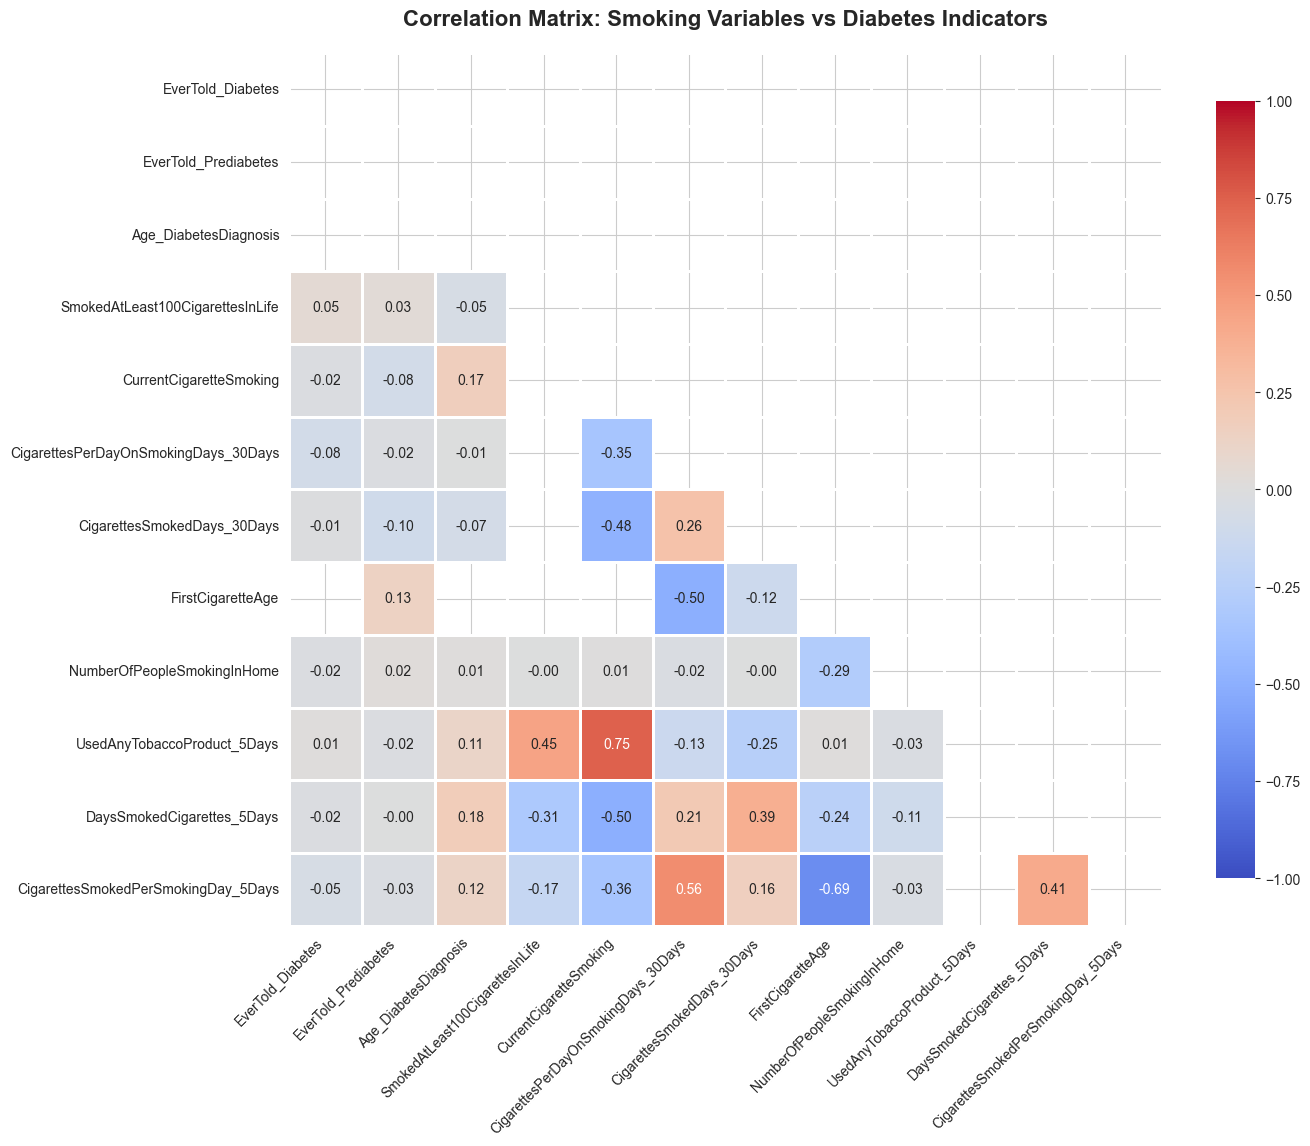


Strongest Correlations with Diabetes:
SmokedAtLeast100CigarettesInLife        0.053135
UsedAnyTobaccoProduct_5Days             0.009400
CigarettesSmokedDays_30Days            -0.007936
NumberOfPeopleSmokingInHome            -0.015719
DaysSmokedCigarettes_5Days             -0.018147
CurrentCigaretteSmoking                -0.019697
CigarettesSmokedPerSmokingDay_5Days    -0.051294
CigarettesPerDayOnSmokingDays_30Days   -0.082736
EverTold_Prediabetes                         NaN
Age_DiabetesDiagnosis                        NaN
Name: EverTold_Diabetes, dtype: float64


In [ ]:
# EDA 7: Correlation Heatmap - Smoking Variables vs Diabetes Indicators
import matplotlib.pyplot as plt
import seaborn as sns

# Select relevant numeric columns
corr_cols = [
    'EverTold_Diabetes',
    'EverTold_Prediabetes', 
    'Age_DiabetesDiagnosis',
    'SmokedAtLeast100CigarettesInLife',
    'CurrentCigaretteSmoking',
    'CigarettesPerDayOnSmokingDays_30Days',
    'CigarettesSmokedDays_30Days',
    'FirstCigaretteAge',
    'NumberOfPeopleSmokingInHome',
    'UsedAnyTobaccoProduct_5Days',
    'DaysSmokedCigarettes_5Days',
    'CigarettesSmokedPerSmokingDay_5Days'
]

# Create correlation matrix
df_corr = df[corr_cols].copy()
correlation_matrix = df_corr.corr()

# Create heatmap
fig, ax = plt.subplots(figsize=(14, 12))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))  # Mask upper triangle

sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8}, ax=ax,
            vmin=-1, vmax=1)

ax.set_title('Correlation Matrix: Smoking Variables vs Diabetes Indicators', 
             fontsize=16, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Print strongest correlations with diabetes
print("\n" + "="*60)
print("Strongest Correlations with Diabetes:")
print("="*60)
diab_corr = correlation_matrix['EverTold_Diabetes'].sort_values(ascending=False)
print(diab_corr[diab_corr.index != 'EverTold_Diabetes'].head(10))


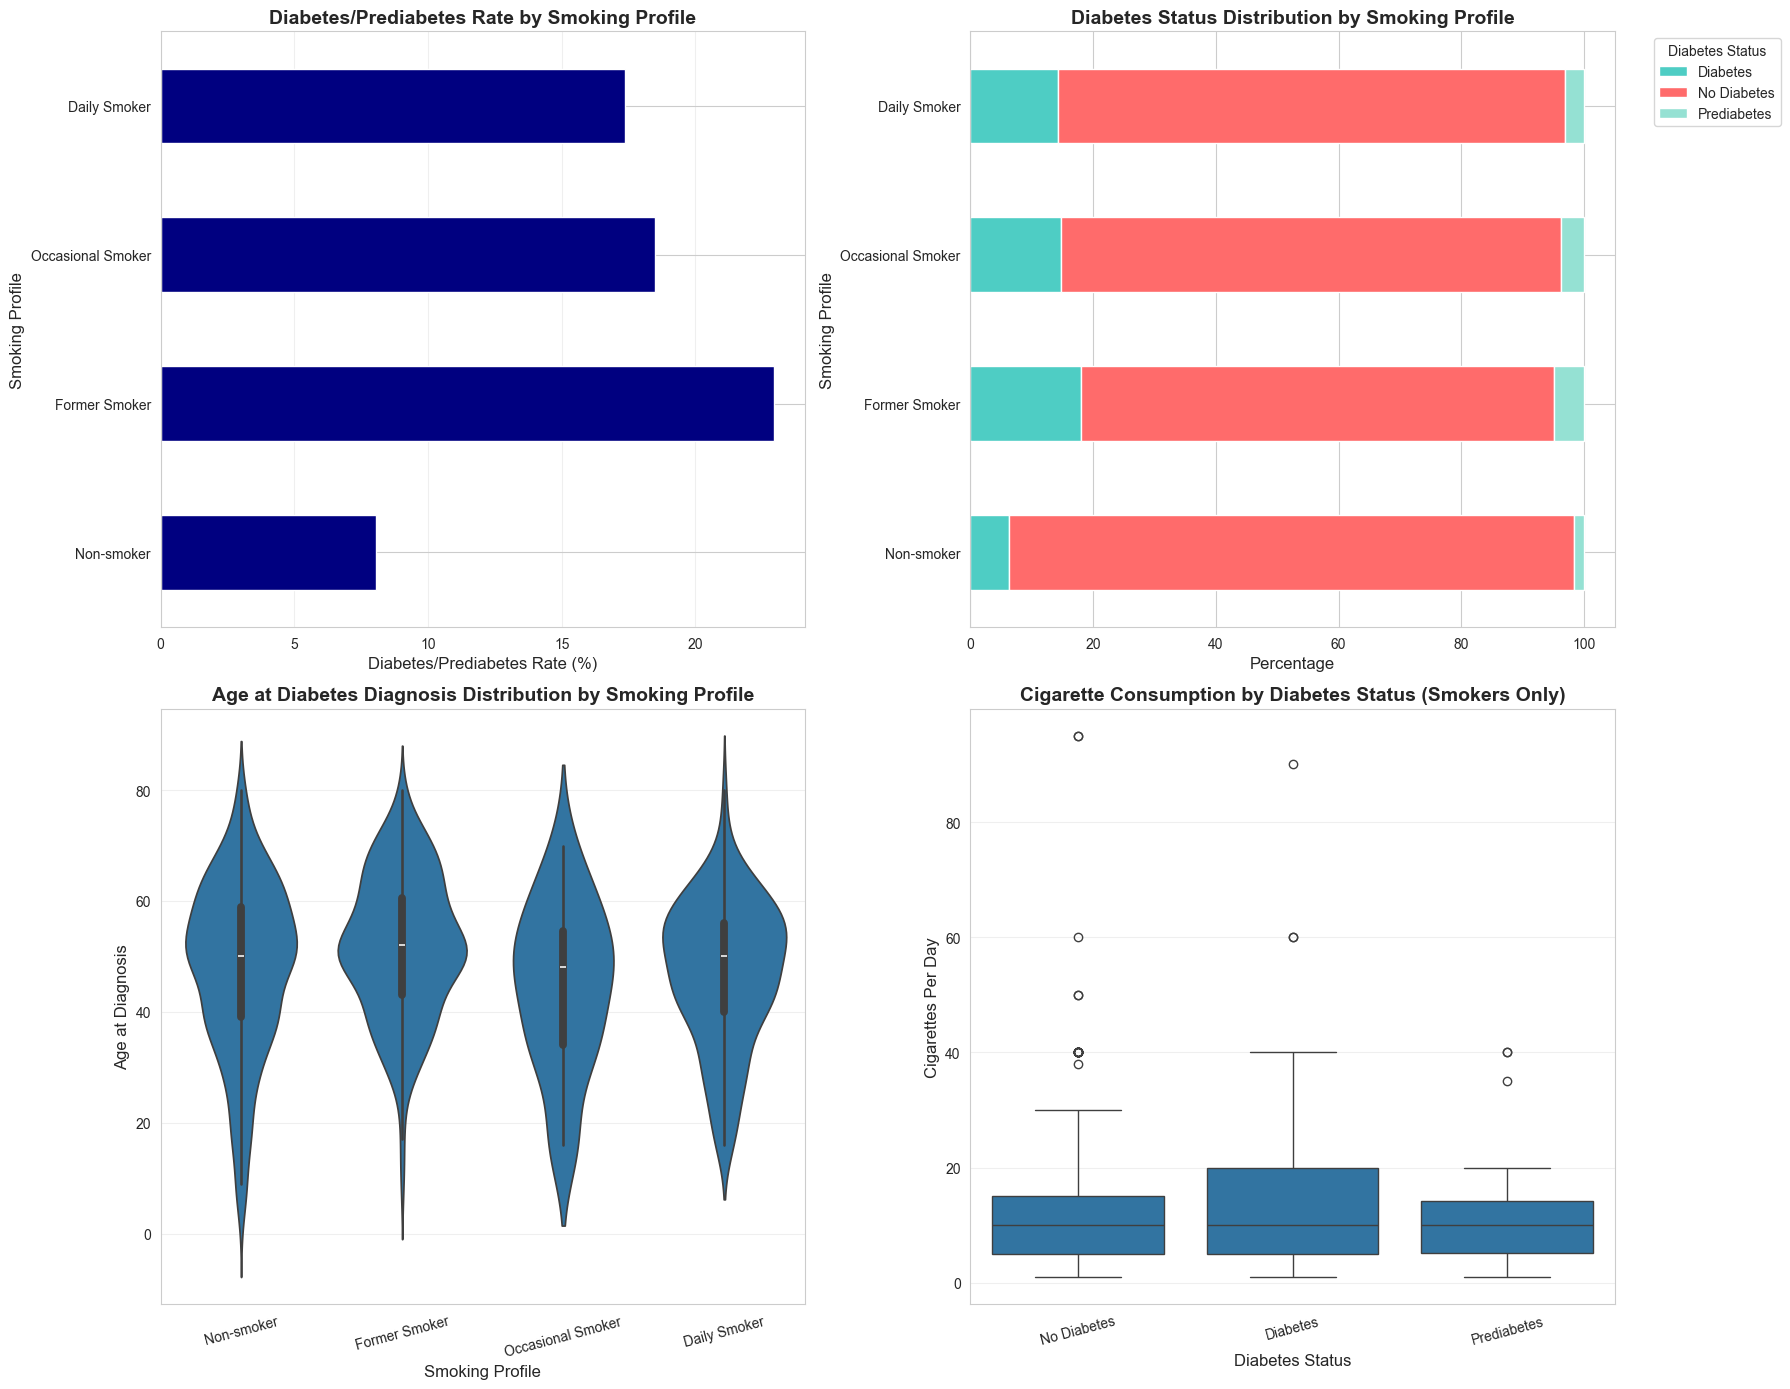


Summary: Diabetes Risk by Smoking Profile

Non-smoker:
  Total: 8494
  Diabetes/Prediabetes Rate: 8.06%
  Breakdown: {'No Diabetes': 7809, 'Diabetes': 540, 'Prediabetes': 145}

Former Smoker:
  Total: 2053
  Diabetes/Prediabetes Rate: 22.94%
  Breakdown: {'No Diabetes': 1582, 'Diabetes': 370, 'Prediabetes': 101}

Occasional Smoker:
  Total: 238
  Diabetes/Prediabetes Rate: 18.49%
  Breakdown: {'No Diabetes': 194, 'Diabetes': 35, 'Prediabetes': 9}

Daily Smoker:
  Total: 951
  Diabetes/Prediabetes Rate: 17.35%
  Breakdown: {'No Diabetes': 786, 'Diabetes': 136, 'Prediabetes': 29}


In [ ]:
# EDA 8: Multi-factor Analysis - Smoking Patterns and Diabetes Risk
fig, axes = plt.subplots(2, 2, figsize=(18, 14))

# Create comprehensive smoking profile
df['Smoking_Profile'] = 'Non-smoker'
df.loc[(df['Ever_Smoked_100'] == 'Yes') & (df['Current_Smoking'] == 'Not at all'), 'Smoking_Profile'] = 'Former Smoker'
df.loc[(df['Ever_Smoked_100'] == 'Yes') & (df['Current_Smoking'] == 'Some days'), 'Smoking_Profile'] = 'Occasional Smoker'
df.loc[(df['Ever_Smoked_100'] == 'Yes') & (df['Current_Smoking'] == 'Every day'), 'Smoking_Profile'] = 'Daily Smoker'

df_profile = df[df['Smoking_Profile'].notna() & df['Diabetes_Status'].notna()].copy()

# Plot 1: Diabetes rate by smoking profile
if len(df_profile) > 0:
    diab_by_profile = df_profile.groupby('Smoking_Profile')['Diabetes_Status'].apply(
        lambda x: (x.isin(['Diabetes', 'Prediabetes']).sum() / len(x) * 100) if len(x) > 0 else 0
    ).reindex(['Non-smoker', 'Former Smoker', 'Occasional Smoker', 'Daily Smoker'])
    
    diab_by_profile.plot(kind='barh', ax=axes[0,0], color='navy')
    axes[0,0].set_title('Diabetes/Prediabetes Rate by Smoking Profile', fontsize=14, fontweight='bold')
    axes[0,0].set_xlabel('Diabetes/Prediabetes Rate (%)', fontsize=12)
    axes[0,0].set_ylabel('Smoking Profile', fontsize=12)
    axes[0,0].grid(axis='x', alpha=0.3)

# Plot 2: Stacked bar - Diabetes status by smoking profile
if len(df_profile) > 0:
    profile_diab_cross = pd.crosstab(df_profile['Smoking_Profile'], df_profile['Diabetes_Status'], 
                                      normalize='index') * 100
    profile_diab_cross = profile_diab_cross.reindex(['Non-smoker', 'Former Smoker', 'Occasional Smoker', 'Daily Smoker'])
    profile_diab_cross.plot(kind='barh', stacked=True, ax=axes[0,1], 
                            color=['#4ecdc4', '#ff6b6b', '#95e1d3'])
    axes[0,1].set_title('Diabetes Status Distribution by Smoking Profile', fontsize=14, fontweight='bold')
    axes[0,1].set_xlabel('Percentage', fontsize=12)
    axes[0,1].set_ylabel('Smoking Profile', fontsize=12)
    axes[0,1].legend(title='Diabetes Status', bbox_to_anchor=(1.05, 1), loc='upper left')

# Plot 3: Age at diagnosis distribution by smoking profile
df_diag_age = df_profile[(df_profile['EverTold_Diabetes'] == 1) & 
                         (df_profile['Age_DiabetesDiagnosis'].notna())].copy()
if len(df_diag_age) > 0:
    sns.violinplot(data=df_diag_age, x='Smoking_Profile', y='Age_DiabetesDiagnosis', 
                   ax=axes[1,0], order=['Non-smoker', 'Former Smoker', 'Occasional Smoker', 'Daily Smoker'])
    axes[1,0].set_title('Age at Diabetes Diagnosis Distribution by Smoking Profile', 
                        fontsize=14, fontweight='bold')
    axes[1,0].set_xlabel('Smoking Profile', fontsize=12)
    axes[1,0].set_ylabel('Age at Diagnosis', fontsize=12)
    axes[1,0].tick_params(axis='x', rotation=15)
    axes[1,0].grid(axis='y', alpha=0.3)

# Plot 4: Cigarette consumption by diabetes status (for smokers only)
df_smokers_cons = df_profile[(df_profile['Smoking_Profile'] != 'Non-smoker') & 
                              (df_profile['Cigarettes_Per_Day'].notna()) &
                              (df_profile['Diabetes_Status'].notna())].copy()
if len(df_smokers_cons) > 0:
    sns.boxplot(data=df_smokers_cons, x='Diabetes_Status', y='Cigarettes_Per_Day', ax=axes[1,1])
    axes[1,1].set_title('Cigarette Consumption by Diabetes Status (Smokers Only)', 
                        fontsize=14, fontweight='bold')
    axes[1,1].set_xlabel('Diabetes Status', fontsize=12)
    axes[1,1].set_ylabel('Cigarettes Per Day', fontsize=12)
    axes[1,1].tick_params(axis='x', rotation=15)
    axes[1,1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Summary statistics
print("\n" + "="*60)
print("Summary: Diabetes Risk by Smoking Profile")
print("="*60)
if len(df_profile) > 0:
    for profile in ['Non-smoker', 'Former Smoker', 'Occasional Smoker', 'Daily Smoker']:
        profile_df = df_profile[df_profile['Smoking_Profile'] == profile]
        if len(profile_df) > 0:
            diab_rate = (profile_df['Diabetes_Status'].isin(['Diabetes', 'Prediabetes']).sum() / 
                        len(profile_df) * 100)
            print(f"\n{profile}:")
            print(f"  Total: {len(profile_df)}")
            print(f"  Diabetes/Prediabetes Rate: {diab_rate:.2f}%")
            print(f"  Breakdown: {profile_df['Diabetes_Status'].value_counts().to_dict()}")


# Machine Learning Baseline: Predicting Diabetes Risk

## Objective
Build baseline models to predict diabetes risk using smoking-related features.

## Steps:
1. **Data Preparation**: Create features and target variable
2. **Choose Evaluation Metrics**: Select appropriate metrics for imbalanced classification
3. **Baseline Models**: Start with simple models
4. **Model Comparison**: Compare performance across different algorithms


In [1]:
# Step 1: Data Preparation for Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')

print("="*70)
print("STEP 1: DATA PREPARATION")
print("="*70)

# Create target variable: Diabetes (1) vs No Diabetes (0)
# We'll combine Diabetes and Prediabetes as positive class (1)
df['Target_Diabetes'] = 0
df.loc[df['EverTold_Diabetes'].isin([1, 3]), 'Target_Diabetes'] = 1  # Diabetes or Prediabetes = 1

print(f"\nTarget variable distribution:")
print(df['Target_Diabetes'].value_counts())
print(f"\nDiabetes/Prediabetes rate: {df['Target_Diabetes'].mean()*100:.2f}%")

# Select features related to smoking that might predict diabetes
feature_cols = [
    # Smoking history
    'SmokedAtLeast100CigarettesInLife',  # Ever smoked 100+ cigarettes
    'CurrentCigaretteSmoking',            # Current smoking frequency
    'FirstCigaretteAge',                  # Age when started smoking
    'CigarettesPerDayOnSmokingDays_30Days',  # Cigarettes per day
    'CigarettesSmokedDays_30Days',       # Days smoked in last 30 days
    
    # Household exposure
    'NumberOfPeopleSmokingInHome',       # Household smokers
    'NumberOfPeopleSmokingInsideHome',    # Indoor smokers
    
    # Recent tobacco use
    'UsedAnyTobaccoProduct_5Days',       # Any tobacco in last 5 days
    'DaysSmokedCigarettes_5Days',         # Days smoked in last 5 days
    'CigarettesSmokedPerSmokingDay_5Days',  # Cigarettes per day (5 days)
    'UsedECigarettes_5Days',             # E-cigarette use
    'UsedSmokelessTobacco_5Days',        # Smokeless tobacco
    
    # Additional diabetes-related features
    'EverTold_Prediabetes',              # Prediabetes history
    'BloodSugarTest_Last3Years'          # Recent blood sugar test
]

# Create feature matrix X and target vector y
X = df[feature_cols].copy()
y = df['Target_Diabetes'].copy()

print(f"\nInitial feature matrix shape: {X.shape}")
print(f"Features: {list(X.columns)}")

# Handle missing values - we'll use median for numeric and most_frequent for categorical
# First, identify numeric vs categorical columns
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = []

print(f"\nNumeric features: {len(numeric_cols)}")
print(f"Categorical features: {len(categorical_cols)}")

# Impute missing values
numeric_imputer = SimpleImputer(strategy='median')
X[numeric_cols] = numeric_imputer.fit_transform(X[numeric_cols])

print(f"\nMissing values after imputation: {X.isna().sum().sum()}")

# Remove rows where target is missing
valid_mask = y.notna()
X = X[valid_mask]
y = y[valid_mask]

print(f"\nFinal feature matrix shape: {X.shape}")
print(f"Final target distribution:")
print(y.value_counts())
print(f"Class balance: {y.mean()*100:.2f}% positive class")


STEP 1: DATA PREPARATION


NameError: name 'df' is not defined

In [ ]:
# Step 2: Train-Test Split and Choose Evaluation Metrics
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                            f1_score, roc_auc_score, confusion_matrix, 
                            classification_report, roc_curve, precision_recall_curve)
import matplotlib.pyplot as plt

print("="*70)
print("STEP 2: TRAIN-TEST SPLIT & EVALUATION METRICS")
print("="*70)

# Split data: 80% train, 20% test
# stratify=y ensures both sets have similar class distribution
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTraining set size: {X_train.shape[0]} ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Test set size: {X_test.shape[0]} ({X_test.shape[0]/len(X)*100:.1f}%)")
print(f"\nTraining set class distribution:")
print(y_train.value_counts())
print(f"Training set diabetes rate: {y_train.mean()*100:.2f}%")
print(f"\nTest set class distribution:")
print(y_test.value_counts())
print(f"Test set diabetes rate: {y_test.mean()*100:.2f}%")

print("\n" + "="*70)
print("WHY THESE METRICS?")
print("="*70)
print("""
For imbalanced classification problems (like diabetes prediction), we need multiple metrics:

1. **Accuracy**: Overall correctness, but can be misleading with imbalanced data
   - Formula: (TP + TN) / (TP + TN + FP + FN)
   - Problem: If 90% don't have diabetes, predicting "no diabetes" always gives 90% accuracy!

2. **Precision**: Of those predicted as diabetic, how many actually are?
   - Formula: TP / (TP + FP)
   - Important for: Minimizing false alarms

3. **Recall (Sensitivity)**: Of actual diabetics, how many did we catch?
   - Formula: TP / (TP + FN)
   - Important for: Not missing actual cases (medical screening!)

4. **F1-Score**: Harmonic mean of precision and recall
   - Formula: 2 * (Precision * Recall) / (Precision + Recall)
   - Balances precision and recall

5. **ROC-AUC**: Area under ROC curve - measures model's ability to distinguish classes
   - Range: 0.5 (random) to 1.0 (perfect)
   - Good for: Overall model performance comparison

For medical problems, RECALL is often most important - we want to catch all diabetics!
""")


In [ ]:
# Step 3: Baseline Model 1 - Dummy Classifier (Always Predict Majority Class)
from sklearn.dummy import DummyClassifier

print("="*70)
print("STEP 3: BASELINE MODEL 1 - DUMMY CLASSIFIER")
print("="*70)
print("""
WHAT IS A BASELINE?
A baseline is the simplest possible model. It helps us understand:
- What's the minimum performance we should beat?
- How much better are our actual models?

DUMMY CLASSIFIER:
This model always predicts the most frequent class (majority class).
If 85% of people don't have diabetes, it predicts "no diabetes" 100% of the time.
""")

# Create and train dummy classifier
dummy_clf = DummyClassifier(strategy='most_frequent', random_state=42)
dummy_clf.fit(X_train, y_train)

# Make predictions
y_pred_dummy = dummy_clf.predict(X_test)
y_pred_proba_dummy = dummy_clf.predict_proba(X_test)[:, 1]

# Calculate metrics
dummy_accuracy = accuracy_score(y_test, y_pred_dummy)
dummy_precision = precision_score(y_test, y_pred_dummy, zero_division=0)
dummy_recall = recall_score(y_test, y_pred_dummy, zero_division=0)
dummy_f1 = f1_score(y_test, y_pred_dummy, zero_division=0)

print(f"\nDummy Classifier Results:")
print(f"  Accuracy:  {dummy_accuracy:.4f} ({dummy_accuracy*100:.2f}%)")
print(f"  Precision: {dummy_precision:.4f}")
print(f"  Recall:    {dummy_recall:.4f}")
print(f"  F1-Score:  {dummy_f1:.4f}")

print(f"\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_dummy))
print(f"\nClassification Report:")
print(classification_report(y_test, y_pred_dummy, target_names=['No Diabetes', 'Diabetes']))

# Store results for comparison
baseline_results = {
    'Dummy Classifier': {
        'Accuracy': dummy_accuracy,
        'Precision': dummy_precision,
        'Recall': dummy_recall,
        'F1-Score': dummy_f1,
        'ROC-AUC': None  # Can't calculate for dummy classifier
    }
}


In [ ]:
# Step 4: Baseline Model 2 - Logistic Regression
from sklearn.linear_model import LogisticRegression

print("="*70)
print("STEP 4: BASELINE MODEL 2 - LOGISTIC REGRESSION")
print("="*70)
print("""
LOGISTIC REGRESSION EXPLAINED:
- Simple, interpretable linear model
- Uses sigmoid function to output probabilities (0 to 1)
- Formula: P(diabetes) = 1 / (1 + e^(-z)) where z = b0 + b1*x1 + b2*x2 + ...
- Coefficients tell us: which features increase/decrease diabetes risk
- Fast to train, good baseline for binary classification

WHY START HERE?
1. Simple and fast
2. Provides interpretable coefficients
3. Works well as baseline before trying complex models
4. Handles imbalanced data with class_weight parameter
""")

# Scale features (important for logistic regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create logistic regression model
# class_weight='balanced' helps with imbalanced data
log_reg = LogisticRegression(
    random_state=42,
    max_iter=1000,
    class_weight='balanced',  # Automatically adjusts for class imbalance
    solver='lbfgs'  # Good solver for small-medium datasets
)

# Train the model
print("\nTraining Logistic Regression...")
log_reg.fit(X_train_scaled, y_train)

# Make predictions
y_pred_lr = log_reg.predict(X_test_scaled)
y_pred_proba_lr = log_reg.predict_proba(X_test_scaled)[:, 1]

# Calculate metrics
lr_accuracy = accuracy_score(y_test, y_pred_lr)
lr_precision = precision_score(y_test, y_pred_lr)
lr_recall = recall_score(y_test, y_pred_lr)
lr_f1 = f1_score(y_test, y_pred_lr)
lr_roc_auc = roc_auc_score(y_test, y_pred_proba_lr)

print(f"\nLogistic Regression Results:")
print(f"  Accuracy:  {lr_accuracy:.4f} ({lr_accuracy*100:.2f}%)")
print(f"  Precision: {lr_precision:.4f}")
print(f"  Recall:    {lr_recall:.4f}")
print(f"  F1-Score:  {lr_f1:.4f}")
print(f"  ROC-AUC:   {lr_roc_auc:.4f}")

print(f"\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_lr))
print(f"\nClassification Report:")
print(classification_report(y_test, y_pred_lr, target_names=['No Diabetes', 'Diabetes']))

# Feature importance (coefficients)
print(f"\nTop 10 Most Important Features (by absolute coefficient):")
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': log_reg.coef_[0]
})
feature_importance['Abs_Coefficient'] = feature_importance['Coefficient'].abs()
feature_importance = feature_importance.sort_values('Abs_Coefficient', ascending=False)
print(feature_importance.head(10))

# Store results
baseline_results['Logistic Regression'] = {
    'Accuracy': lr_accuracy,
    'Precision': lr_precision,
    'Recall': lr_recall,
    'F1-Score': lr_f1,
    'ROC-AUC': lr_roc_auc
}


In [ ]:
# Step 5: Baseline Model 3 - Naive Bayes
from sklearn.naive_bayes import GaussianNB

print("="*70)
print("STEP 5: BASELINE MODEL 3 - NAIVE BAYES")
print("="*70)
print("""
NAIVE BAYES EXPLAINED:
- Based on Bayes' Theorem: P(A|B) = P(B|A) * P(A) / P(B)
- "Naive" because it assumes features are independent (not always true!)
- Formula: P(diabetes|features) ∝ P(features|diabetes) * P(diabetes)
- Fast, simple, works well with small datasets
- Good for baseline comparison

WHY USE IT?
1. Very fast training and prediction
2. Works well with small datasets
3. Handles missing values naturally
4. Probabilistic output (like logistic regression)
""")

# Create Naive Bayes model
nb_clf = GaussianNB()

# Train the model
print("\nTraining Naive Bayes...")
nb_clf.fit(X_train_scaled, y_train)

# Make predictions
y_pred_nb = nb_clf.predict(X_test_scaled)
y_pred_proba_nb = nb_clf.predict_proba(X_test_scaled)[:, 1]

# Calculate metrics
nb_accuracy = accuracy_score(y_test, y_pred_nb)
nb_precision = precision_score(y_test, y_pred_nb)
nb_recall = recall_score(y_test, y_pred_nb)
nb_f1 = f1_score(y_test, y_pred_nb)
nb_roc_auc = roc_auc_score(y_test, y_pred_proba_nb)

print(f"\nNaive Bayes Results:")
print(f"  Accuracy:  {nb_accuracy:.4f} ({nb_accuracy*100:.2f}%)")
print(f"  Precision: {nb_precision:.4f}")
print(f"  Recall:    {nb_recall:.4f}")
print(f"  F1-Score:  {nb_f1:.4f}")
print(f"  ROC-AUC:   {nb_roc_auc:.4f}")

print(f"\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_nb))
print(f"\nClassification Report:")
print(classification_report(y_test, y_pred_nb, target_names=['No Diabetes', 'Diabetes']))

# Store results
baseline_results['Naive Bayes'] = {
    'Accuracy': nb_accuracy,
    'Precision': nb_precision,
    'Recall': nb_recall,
    'F1-Score': nb_f1,
    'ROC-AUC': nb_roc_auc
}


In [ ]:
# Step 6: Baseline Model 4 - Decision Tree
from sklearn.tree import DecisionTreeClassifier

print("="*70)
print("STEP 6: BASELINE MODEL 4 - DECISION TREE")
print("="*70)
print("""
DECISION TREE EXPLAINED:
- Tree-like model that splits data based on feature values
- Each node asks a question (e.g., "Did you smoke 100+ cigarettes?")
- Branches lead to decisions (Yes/No)
- Leaf nodes give final prediction
- Very interpretable - you can visualize the tree!

WHY USE IT?
1. Highly interpretable (can see decision rules)
2. No need for feature scaling
3. Handles non-linear relationships
4. Can show which features matter most
""")

# Create Decision Tree model
# max_depth limits tree complexity to prevent overfitting
dt_clf = DecisionTreeClassifier(
    random_state=42,
    max_depth=5,  # Limit depth to prevent overfitting
    class_weight='balanced',
    min_samples_split=20,  # Minimum samples to split a node
    min_samples_leaf=10    # Minimum samples in a leaf
)

# Train the model
print("\nTraining Decision Tree...")
dt_clf.fit(X_train, y_train)  # No scaling needed for trees!

# Make predictions
y_pred_dt = dt_clf.predict(X_test)
y_pred_proba_dt = dt_clf.predict_proba(X_test)[:, 1]

# Calculate metrics
dt_accuracy = accuracy_score(y_test, y_pred_dt)
dt_precision = precision_score(y_test, y_pred_dt)
dt_recall = recall_score(y_test, y_pred_dt)
dt_f1 = f1_score(y_test, y_pred_dt)
dt_roc_auc = roc_auc_score(y_test, y_pred_proba_dt)

print(f"\nDecision Tree Results:")
print(f"  Accuracy:  {dt_accuracy:.4f} ({dt_accuracy*100:.2f}%)")
print(f"  Precision: {dt_precision:.4f}")
print(f"  Recall:    {dt_recall:.4f}")
print(f"  F1-Score:  {dt_f1:.4f}")
print(f"  ROC-AUC:   {dt_roc_auc:.4f}")

print(f"\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_dt))
print(f"\nClassification Report:")
print(classification_report(y_test, y_pred_dt, target_names=['No Diabetes', 'Diabetes']))

# Feature importance
print(f"\nTop 10 Most Important Features:")
feature_importance_dt = pd.DataFrame({
    'Feature': X.columns,
    'Importance': dt_clf.feature_importances_
}).sort_values('Importance', ascending=False)
print(feature_importance_dt.head(10))

# Store results
baseline_results['Decision Tree'] = {
    'Accuracy': dt_accuracy,
    'Precision': dt_precision,
    'Recall': dt_recall,
    'F1-Score': dt_f1,
    'ROC-AUC': dt_roc_auc
}


In [ ]:
# Step 7: Compare All Baseline Models
print("="*70)
print("STEP 7: BASELINE MODEL COMPARISON")
print("="*70)

# Create comparison DataFrame
comparison_df = pd.DataFrame(baseline_results).T
comparison_df = comparison_df.sort_values('F1-Score', ascending=False)

print("\nModel Performance Comparison:")
print(comparison_df.round(4))

# Visualize comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Accuracy comparison
comparison_df['Accuracy'].plot(kind='barh', ax=axes[0,0], color='steelblue')
axes[0,0].set_title('Accuracy Comparison', fontsize=14, fontweight='bold')
axes[0,0].set_xlabel('Accuracy', fontsize=12)
axes[0,0].grid(axis='x', alpha=0.3)

# Plot 2: Precision vs Recall
axes[0,1].scatter(comparison_df['Precision'], comparison_df['Recall'], 
                  s=200, alpha=0.6, c=['red', 'blue', 'green', 'orange'])
for idx, model in enumerate(comparison_df.index):
    axes[0,1].annotate(model, 
                      (comparison_df['Precision'].iloc[idx], 
                       comparison_df['Recall'].iloc[idx]),
                      fontsize=10)
axes[0,1].set_title('Precision vs Recall', fontsize=14, fontweight='bold')
axes[0,1].set_xlabel('Precision', fontsize=12)
axes[0,1].set_ylabel('Recall', fontsize=12)
axes[0,1].grid(alpha=0.3)

# Plot 3: F1-Score comparison
comparison_df['F1-Score'].plot(kind='barh', ax=axes[1,0], color='coral')
axes[1,0].set_title('F1-Score Comparison', fontsize=14, fontweight='bold')
axes[1,0].set_xlabel('F1-Score', fontsize=12)
axes[1,0].grid(axis='x', alpha=0.3)

# Plot 4: ROC-AUC comparison (excluding dummy classifier)
roc_comparison = comparison_df[comparison_df['ROC-AUC'].notna()]
roc_comparison['ROC-AUC'].plot(kind='barh', ax=axes[1,1], color='teal')
axes[1,1].set_title('ROC-AUC Comparison', fontsize=14, fontweight='bold')
axes[1,1].set_xlabel('ROC-AUC', fontsize=12)
axes[1,1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

# ROC Curves
fig, ax = plt.subplots(figsize=(10, 8))

# Plot ROC curves for all models
if y_pred_proba_lr is not None:
    fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_proba_lr)
    ax.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC={lr_roc_auc:.3f})', linewidth=2)

if y_pred_proba_nb is not None:
    fpr_nb, tpr_nb, _ = roc_curve(y_test, y_pred_proba_nb)
    ax.plot(fpr_nb, tpr_nb, label=f'Naive Bayes (AUC={nb_roc_auc:.3f})', linewidth=2)

if y_pred_proba_dt is not None:
    fpr_dt, tpr_dt, _ = roc_curve(y_test, y_pred_proba_dt)
    ax.plot(fpr_dt, tpr_dt, label=f'Decision Tree (AUC={dt_roc_auc:.3f})', linewidth=2)

# Diagonal line (random classifier)
ax.plot([0, 1], [0, 1], 'k--', label='Random Classifier (AUC=0.5)', linewidth=1)

ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate (Recall)', fontsize=12)
ax.set_title('ROC Curves: Baseline Models Comparison', fontsize=14, fontweight='bold')
ax.legend(loc='lower right', fontsize=10)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("KEY INSIGHTS:")
print("="*70)
print(f"""
1. Best F1-Score: {comparison_df.index[0]} ({comparison_df['F1-Score'].iloc[0]:.4f})
2. Best Recall: {comparison_df.loc[comparison_df['Recall'].idxmax()].name} ({comparison_df['Recall'].max():.4f})
   - Important for medical screening - we want to catch all diabetics!
3. Best Precision: {comparison_df.loc[comparison_df['Precision'].idxmax()].name} ({comparison_df['Precision'].max():.4f})
   - Important to minimize false alarms
4. Best ROC-AUC: {roc_comparison.loc[roc_comparison['ROC-AUC'].idxmax()].name} ({roc_comparison['ROC-AUC'].max():.4f})
   - Overall model discrimination ability

NEXT STEPS:
- Try more complex models (Random Forest, XGBoost, Neural Networks)
- Feature engineering (create new features from existing ones)
- Hyperparameter tuning (optimize model parameters)
- Cross-validation (more robust evaluation)
""")


In [ ]:
# Step 8: Statistical Analysis - Understanding Relationships
from scipy import stats
from scipy.stats import chi2_contingency

print("="*70)
print("STEP 8: STATISTICAL ANALYSIS")
print("="*70)
print("""
STATISTICAL TESTS HELP US UNDERSTAND:
- Which features are significantly associated with diabetes?
- Are relationships statistically significant or just random?
- How strong are the associations?

WE'LL USE:
1. Chi-square test: For categorical features vs diabetes
2. T-test: For continuous features vs diabetes
3. Correlation analysis: Relationships between features
""")

# Statistical test 1: Chi-square for categorical features
print("\n" + "-"*70)
print("CHI-SQUARE TESTS (Categorical Features vs Diabetes)")
print("-"*70)

categorical_features = [
    'SmokedAtLeast100CigarettesInLife',
    'CurrentCigaretteSmoking',
    'UsedAnyTobaccoProduct_5Days',
    'UsedECigarettes_5Days',
    'EverTold_Prediabetes'
]

for feature in categorical_features:
    if feature in X.columns:
        # Create contingency table
        contingency = pd.crosstab(df[feature], df['Target_Diabetes'])
        
        # Perform chi-square test
        chi2, p_value, dof, expected = chi2_contingency(contingency)
        
        print(f"\n{feature}:")
        print(f"  Chi-square statistic: {chi2:.4f}")
        print(f"  P-value: {p_value:.6f}")
        print(f"  Significant? {'Yes' if p_value < 0.05 else 'No'} (p < 0.05)")
        print(f"  Contingency table:")
        print(contingency)

# Statistical test 2: T-test for continuous features
print("\n" + "-"*70)
print("T-TESTS (Continuous Features: Diabetics vs Non-Diabetics)")
print("-"*70)

continuous_features = [
    'FirstCigaretteAge',
    'CigarettesPerDayOnSmokingDays_30Days',
    'CigarettesSmokedDays_30Days',
    'NumberOfPeopleSmokingInHome',
    'DaysSmokedCigarettes_5Days'
]

for feature in continuous_features:
    if feature in X.columns:
        # Split into diabetics and non-diabetics
        diabetics = df[df['Target_Diabetes'] == 1][feature].dropna()
        non_diabetics = df[df['Target_Diabetes'] == 0][feature].dropna()
        
        if len(diabetics) > 0 and len(non_diabetics) > 0:
            # Perform t-test
            t_stat, p_value = stats.ttest_ind(diabetics, non_diabetics)
            
            print(f"\n{feature}:")
            print(f"  Diabetics mean: {diabetics.mean():.2f} (n={len(diabetics)})")
            print(f"  Non-diabetics mean: {non_diabetics.mean():.2f} (n={len(non_diabetics)})")
            print(f"  T-statistic: {t_stat:.4f}")
            print(f"  P-value: {p_value:.6f}")
            print(f"  Significant difference? {'Yes' if p_value < 0.05 else 'No'} (p < 0.05)")

print("\n" + "="*70)
print("INTERPRETATION:")
print("="*70)
print("""
- P-value < 0.05: Statistically significant relationship (not due to chance)
- Lower p-value = stronger evidence of relationship
- These tests help validate which features should be in our model
""")


# Diabetes Prediction Model - Final Pipeline

## Objective
Predict diabetes without using "giveaway" features (like blood sugar tests, diabetes diagnosis, etc.)

## Approach:
1. **Load & Merge Data**: Combine all cleaned datasets
2. **Create Target**: Diabetes (1) vs No Diabetes (0)
3. **Remove Giveaway Features**: Blood sugar tests, diabetes-related features
4. **Feature Selection**: Correlation analysis + feature importance
5. **Model Comparison**: Try multiple algorithms
6. **Best Model Selection**: Cross-validation + comprehensive metrics
7. **Final Model Training**: Train best model on full data


In [11]:
# Step 1: Load and Merge All Cleaned Datasets
import pandas as pd
import numpy as np
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

print("="*70)
print("STEP 1: LOADING AND MERGING ALL DATASETS")
print("="*70)

DATA_DIR = Path('data')

# List of all dataset files to merge
dataset_files = [
    'diabetes.csv',
    'smoking_cigarette_use.csv',
    'smoking_household_smokers.csv',
    'smoking_recent_tobacco_use.csv',
    'blood_pressure_cholesterol.csv',
    'alcohol_use.csv',
    'physical_activity.csv',
    'diet_behavior_nutrition.csv',
    'weight_history.csv',
    'medical_conditions.csv',
    'mental_health_depression_screener.csv',
    'current_health_status.csv',
    'functioning.csv',
    'health_insurance.csv',
    'income.csv',
    'housing_characteristics.csv',
    'occupation.csv'
]

# Start with diabetes dataset (has our target)
df = pd.read_csv(DATA_DIR / 'diabetes.csv')
print(f"\nStarting with diabetes.csv: {df.shape}")

# Merge all other datasets
for file in dataset_files[1:]:  # Skip diabetes (already loaded)
    file_path = DATA_DIR / file
    if file_path.exists():
        df_temp = pd.read_csv(file_path)
        # Merge on sequence_no, using suffixes to avoid column name conflicts
        df = df.merge(df_temp, on='sequence_no', how='outer', suffixes=('', f'_{file.split(".")[0]}'))
        print(f"Merged {file}: {df.shape}")
    else:
        print(f"Warning: {file} not found, skipping...")

print(f"\nFinal merged dataset shape: {df.shape}")
print(f"Total columns: {len(df.columns)}")
print(f"Total rows: {len(df)}")

# Check for duplicate sequence_no
if df['sequence_no'].duplicated().any():
    print(f"\nWarning: {df['sequence_no'].duplicated().sum()} duplicate sequence_no found")
    df = df.drop_duplicates(subset='sequence_no', keep='first')
    print(f"After removing duplicates: {df.shape}")


STEP 1: LOADING AND MERGING ALL DATASETS

Starting with diabetes.csv: (11744, 5)
Merged smoking_cigarette_use.csv: (11744, 9)
Merged smoking_household_smokers.csv: (11933, 11)
Merged smoking_recent_tobacco_use.csv: (11933, 20)
Merged blood_pressure_cholesterol.csv: (11933, 25)
Merged alcohol_use.csv: (11933, 33)
Merged physical_activity.csv: (11933, 38)
Merged diet_behavior_nutrition.csv: (11933, 55)
Merged weight_history.csv: (11933, 59)
Merged medical_conditions.csv: (11933, 80)
Merged mental_health_depression_screener.csv: (11933, 89)
Merged current_health_status.csv: (11933, 90)
Merged functioning.csv: (11933, 120)
Merged health_insurance.csv: (11933, 125)
Merged income.csv: (11933, 129)
Merged housing_characteristics.csv: (11933, 130)
Merged occupation.csv: (11933, 135)

Final merged dataset shape: (11933, 135)
Total columns: 135
Total rows: 11933


In [12]:
# Step 2: Create Target Variable and Remove Giveaway Features
print("="*70)
print("STEP 2: CREATE TARGET & REMOVE GIVEAWAY FEATURES")
print("="*70)

# Create target: Diabetes (1) or No Diabetes (0)
# Combine Diabetes (1) and Prediabetes (3) as positive class
df['Target_Diabetes'] = 0
df.loc[df['EverTold_Diabetes'].isin([1, 3]), 'Target_Diabetes'] = 1

print(f"\nTarget variable distribution:")
print(df['Target_Diabetes'].value_counts())
print(f"Diabetes/Prediabetes rate: {df['Target_Diabetes'].mean()*100:.2f}%")

# Define GIVEAWAY features to remove (these would make prediction too easy)
giveaway_features = [
    # Direct diabetes indicators
    'EverTold_Diabetes',           # Direct diagnosis
    'EverTold_Prediabetes',        # Prediabetes diagnosis
    'Age_DiabetesDiagnosis',       # Age at diagnosis
    'CurrentlyTaking_Insulin',     # Taking insulin = has diabetes
    'CurrentlyTaking_DiabeticPills', # Taking diabetic pills = has diabetes
    'InsulinDuration',             # Insulin duration
    'BloodSugarTest_Last3Years',   # Blood sugar test (giveaway!)
    
    # Any other obvious diabetes-related features
    'Target_Diabetes'  # Don't include target in features!
]

# Remove giveaway features
features_to_remove = [f for f in giveaway_features if f in df.columns]
print(f"\nRemoving {len(features_to_remove)} giveaway features:")
for f in features_to_remove:
    print(f"  - {f}")

df_features = df.drop(columns=features_to_remove, errors='ignore')

# Also remove sequence_no (it's just an ID)
if 'sequence_no' in df_features.columns:
    df_features = df_features.drop(columns=['sequence_no'])

print(f"\nFeatures after removal: {df_features.shape[1]} columns")
print(f"Target variable: {df['Target_Diabetes'].sum()} diabetics, {len(df) - df['Target_Diabetes'].sum()} non-diabetics")


STEP 2: CREATE TARGET & REMOVE GIVEAWAY FEATURES

Target variable distribution:
Target_Diabetes
0    10568
1     1365
Name: count, dtype: int64
Diabetes/Prediabetes rate: 11.44%

Removing 5 giveaway features:
  - EverTold_Diabetes
  - EverTold_Prediabetes
  - CurrentlyTaking_DiabeticPills
  - BloodSugarTest_Last3Years
  - Target_Diabetes

Features after removal: 130 columns
Target variable: 1365 diabetics, 10568 non-diabetics


STEP 3: FEATURE SELECTION - CORRELATION ANALYSIS

Top 30 Features Correlated with Diabetes:
                                Feature  Correlation  Abs_Correlation
  CurrentlyTaking_CholesterolMedication    -0.363766         0.363766
                  EverTold_Hypertension    -0.315932         0.315932
               EverTold_HighCholesterol    -0.291683         0.291683
   DifficultyWalkingClimbingSteps_Level     0.271719         0.271719
      DifficultyUsingHandsFingers_Level     0.177978         0.177978
                WorkExperience_LastWeek     0.175349         0.175349
               AdultDisabilityIndicator    -0.172297         0.172297
        EverTold_CongestiveHeartFailure    -0.171891         0.171891
                     EverTold_Arthritis    -0.169958         0.169958
          EverTold_CoronaryHeartDisease    -0.166034         0.166034
       AdultEnhancedDisabilityIndicator    -0.162222         0.162222
                   EverTold_HeartAttack    -0.153915         0.15391

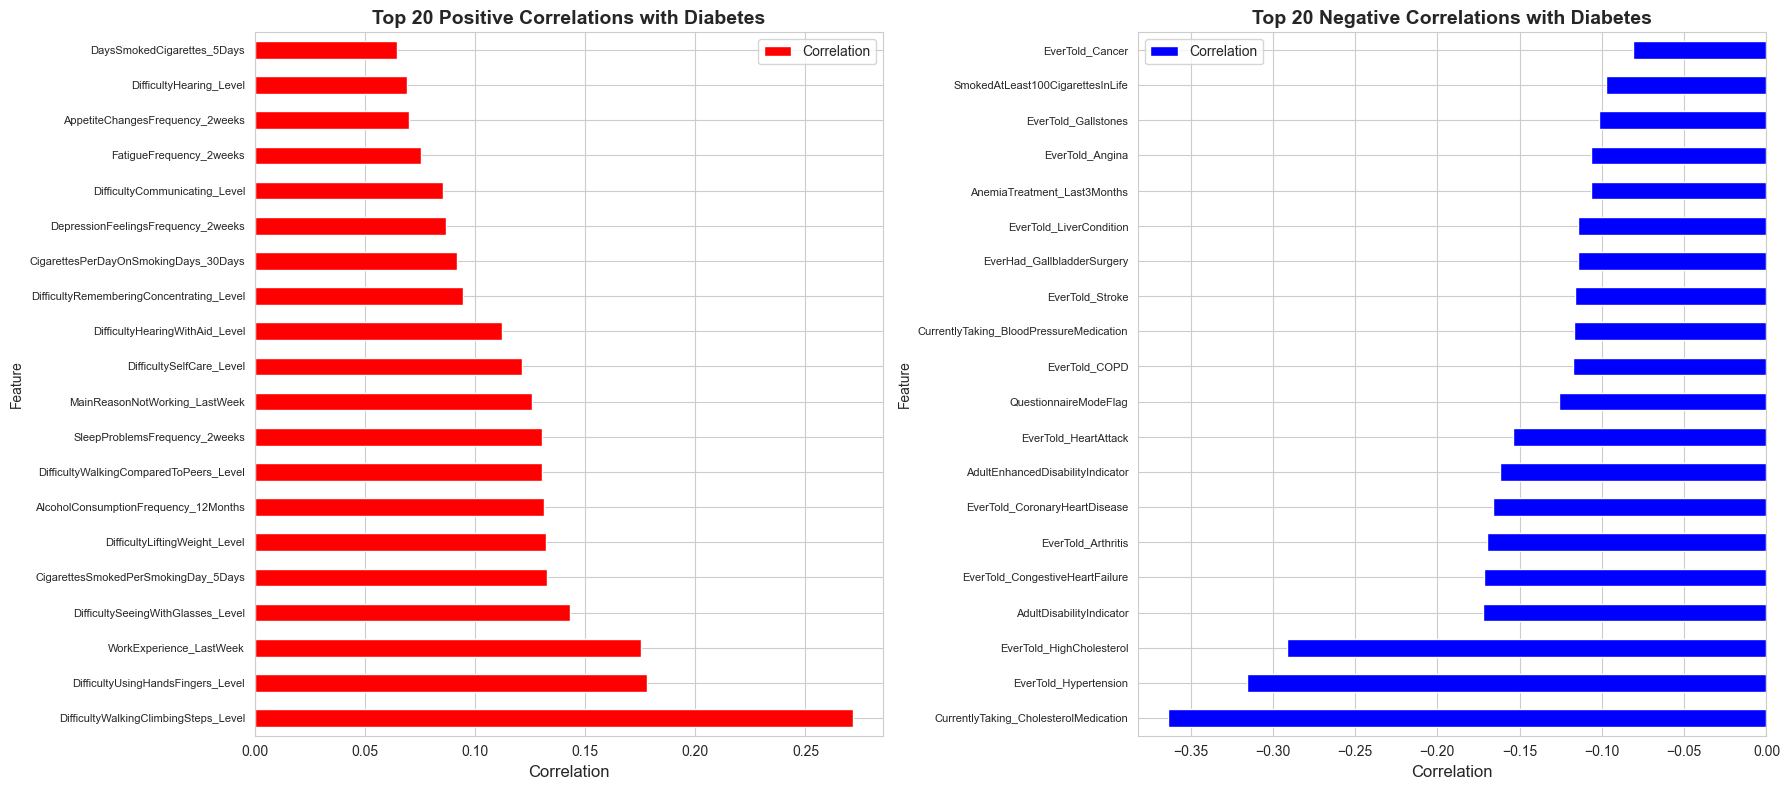


Selected 50 top correlated features for modeling
Correlation range: -0.364 to 0.272


In [13]:
# Step 3: Feature Selection - Correlation Analysis
import matplotlib.pyplot as plt
import seaborn as sns

print("="*70)
print("STEP 3: FEATURE SELECTION - CORRELATION ANALYSIS")
print("="*70)

# Prepare data for correlation
X_all = df_features.copy()
y = df['Target_Diabetes'].copy()

# Remove rows where target is missing
valid_mask = y.notna()
X_all = X_all[valid_mask]
y = y[valid_mask]

# Convert all to numeric and handle missing values
for col in X_all.columns:
    X_all[col] = pd.to_numeric(X_all[col], errors='coerce')

# Calculate correlation with target
correlations = {}
for col in X_all.columns:
    if X_all[col].notna().sum() > 100:  # Only if enough non-null values
        corr = X_all[col].corr(y)
        if not pd.isna(corr):
            correlations[col] = corr

# Sort by absolute correlation
corr_df = pd.DataFrame({
    'Feature': list(correlations.keys()),
    'Correlation': list(correlations.values())
})
corr_df['Abs_Correlation'] = corr_df['Correlation'].abs()
corr_df = corr_df.sort_values('Abs_Correlation', ascending=False)

print(f"\nTop 30 Features Correlated with Diabetes:")
print(corr_df.head(30).to_string(index=False))

# Visualize top correlations
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Plot 1: Top 20 positive correlations
top_positive = corr_df[corr_df['Correlation'] > 0].head(20)
top_positive.plot(x='Feature', y='Correlation', kind='barh', ax=axes[0], color='red')
axes[0].set_title('Top 20 Positive Correlations with Diabetes', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Correlation', fontsize=12)
axes[0].tick_params(axis='y', labelsize=8)

# Plot 2: Top 20 negative correlations
top_negative = corr_df[corr_df['Correlation'] < 0].head(20)
if len(top_negative) > 0:
    top_negative.plot(x='Feature', y='Correlation', kind='barh', ax=axes[1], color='blue')
    axes[1].set_title('Top 20 Negative Correlations with Diabetes', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Correlation', fontsize=12)
    axes[1].tick_params(axis='y', labelsize=8)

plt.tight_layout()
plt.show()

# Select top features based on correlation
top_n_features = 50  # Select top 50 most correlated features
selected_features = corr_df.head(top_n_features)['Feature'].tolist()

print(f"\nSelected {len(selected_features)} top correlated features for modeling")
print(f"Correlation range: {corr_df.head(top_n_features)['Correlation'].min():.3f} to {corr_df.head(top_n_features)['Correlation'].max():.3f}")


In [14]:
# Step 4: Prepare Final Feature Matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

print("="*70)
print("STEP 4: PREPARE FINAL FEATURE MATRIX")
print("="*70)

# Select features
X = X_all[selected_features].copy()

print(f"\nFeature matrix shape: {X.shape}")
print(f"Missing values: {X.isna().sum().sum()} ({X.isna().sum().sum()/(X.shape[0]*X.shape[1])*100:.2f}%)")

# Impute missing values with median
imputer = SimpleImputer(strategy='median')
X_imputed = pd.DataFrame(
    imputer.fit_transform(X),
    columns=X.columns,
    index=X.index
)

print(f"After imputation - Missing values: {X_imputed.isna().sum().sum()}")

# Train-test split (80-20)
X_train, X_test, y_train, y_test = train_test_split(
    X_imputed, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTrain set: {X_train.shape[0]} samples ({X_train.shape[0]/len(X_imputed)*100:.1f}%)")
print(f"Test set: {X_test.shape[0]} samples ({X_test.shape[0]/len(X_imputed)*100:.1f}%)")
print(f"\nTrain set diabetes rate: {y_train.mean()*100:.2f}%")
print(f"Test set diabetes rate: {y_test.mean()*100:.2f}%")

# Scale features (important for some models)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print(f"\n✓ Data prepared and scaled!")


STEP 4: PREPARE FINAL FEATURE MATRIX

Feature matrix shape: (11933, 50)
Missing values: 291331 (48.83%)
After imputation - Missing values: 0

Train set: 9546 samples (80.0%)
Test set: 2387 samples (20.0%)

Train set diabetes rate: 11.44%
Test set diabetes rate: 11.44%

✓ Data prepared and scaled!


In [15]:
# Step 5: Model Comparison - Try Multiple Algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                            f1_score, roc_auc_score, confusion_matrix, 
                            classification_report, roc_curve)

print("="*70)
print("STEP 5: MODEL COMPARISON")
print("="*70)

# Define models to compare
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced'),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced', n_jobs=-1),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(probability=True, random_state=42, class_weight='balanced'),
    'Naive Bayes': GaussianNB(),
    'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5)
}

# Cross-validation setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Evaluate each model
model_results = {}

print("\nEvaluating models with 5-fold cross-validation...")
print("-"*70)

for name, model in models.items():
    print(f"\n{name}...")
    
    # Use scaled data for models that need it
    if name in ['Logistic Regression', 'SVM', 'K-Nearest Neighbors', 'Naive Bayes']:
        X_train_model = X_train_scaled
        X_test_model = X_test_scaled
    else:
        X_train_model = X_train
        X_test_model = X_test
    
    # Cross-validation scores
    cv_scores = cross_val_score(model, X_train_model, y_train, cv=cv, 
                                scoring='roc_auc', n_jobs=-1)
    
    # Train on full training set
    model.fit(X_train_model, y_train)
    
    # Predictions
    y_pred = model.predict(X_test_model)
    y_pred_proba = model.predict_proba(X_test_model)[:, 1]
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    # Store results
    model_results[name] = {
        'CV_ROC_AUC_Mean': cv_scores.mean(),
        'CV_ROC_AUC_Std': cv_scores.std(),
        'Test_Accuracy': accuracy,
        'Test_Precision': precision,
        'Test_Recall': recall,
        'Test_F1': f1,
        'Test_ROC_AUC': roc_auc,
        'Model': model
    }
    
    print(f"  CV ROC-AUC: {cv_scores.mean():.4f} (+/- {cv_scores.std()*2:.4f})")
    print(f"  Test Accuracy: {accuracy:.4f}")
    print(f"  Test F1-Score: {f1:.4f}")
    print(f"  Test ROC-AUC: {roc_auc:.4f}")

# Create comparison DataFrame
results_df = pd.DataFrame(model_results).T
results_df = results_df.sort_values('Test_ROC_AUC', ascending=False)

print("\n" + "="*70)
print("MODEL COMPARISON RESULTS")
print("="*70)
print(results_df[['CV_ROC_AUC_Mean', 'Test_Accuracy', 'Test_Precision', 
                  'Test_Recall', 'Test_F1', 'Test_ROC_AUC']].round(4))


STEP 5: MODEL COMPARISON

Evaluating models with 5-fold cross-validation...
----------------------------------------------------------------------

Logistic Regression...
  CV ROC-AUC: 0.8699 (+/- 0.0157)
  Test Accuracy: 0.7968
  Test F1-Score: 0.4711
  Test ROC-AUC: 0.8762

Random Forest...
  CV ROC-AUC: 0.8408 (+/- 0.0173)
  Test Accuracy: 0.8932
  Test F1-Score: 0.2478
  Test ROC-AUC: 0.8544

Gradient Boosting...
  CV ROC-AUC: 0.8700 (+/- 0.0193)
  Test Accuracy: 0.8848
  Test F1-Score: 0.2857
  Test ROC-AUC: 0.8804

SVM...
  CV ROC-AUC: 0.8312 (+/- 0.0102)
  Test Accuracy: 0.8085
  Test F1-Score: 0.4501
  Test ROC-AUC: 0.8563

Naive Bayes...
  CV ROC-AUC: 0.8280 (+/- 0.0415)
  Test Accuracy: 0.7746
  Test F1-Score: 0.3872
  Test ROC-AUC: 0.8145

K-Nearest Neighbors...
  CV ROC-AUC: 0.7446 (+/- 0.0045)
  Test Accuracy: 0.8785
  Test F1-Score: 0.1989
  Test ROC-AUC: 0.7422

MODEL COMPARISON RESULTS
                    CV_ROC_AUC_Mean Test_Accuracy Test_Precision Test_Recall  \
Gradi

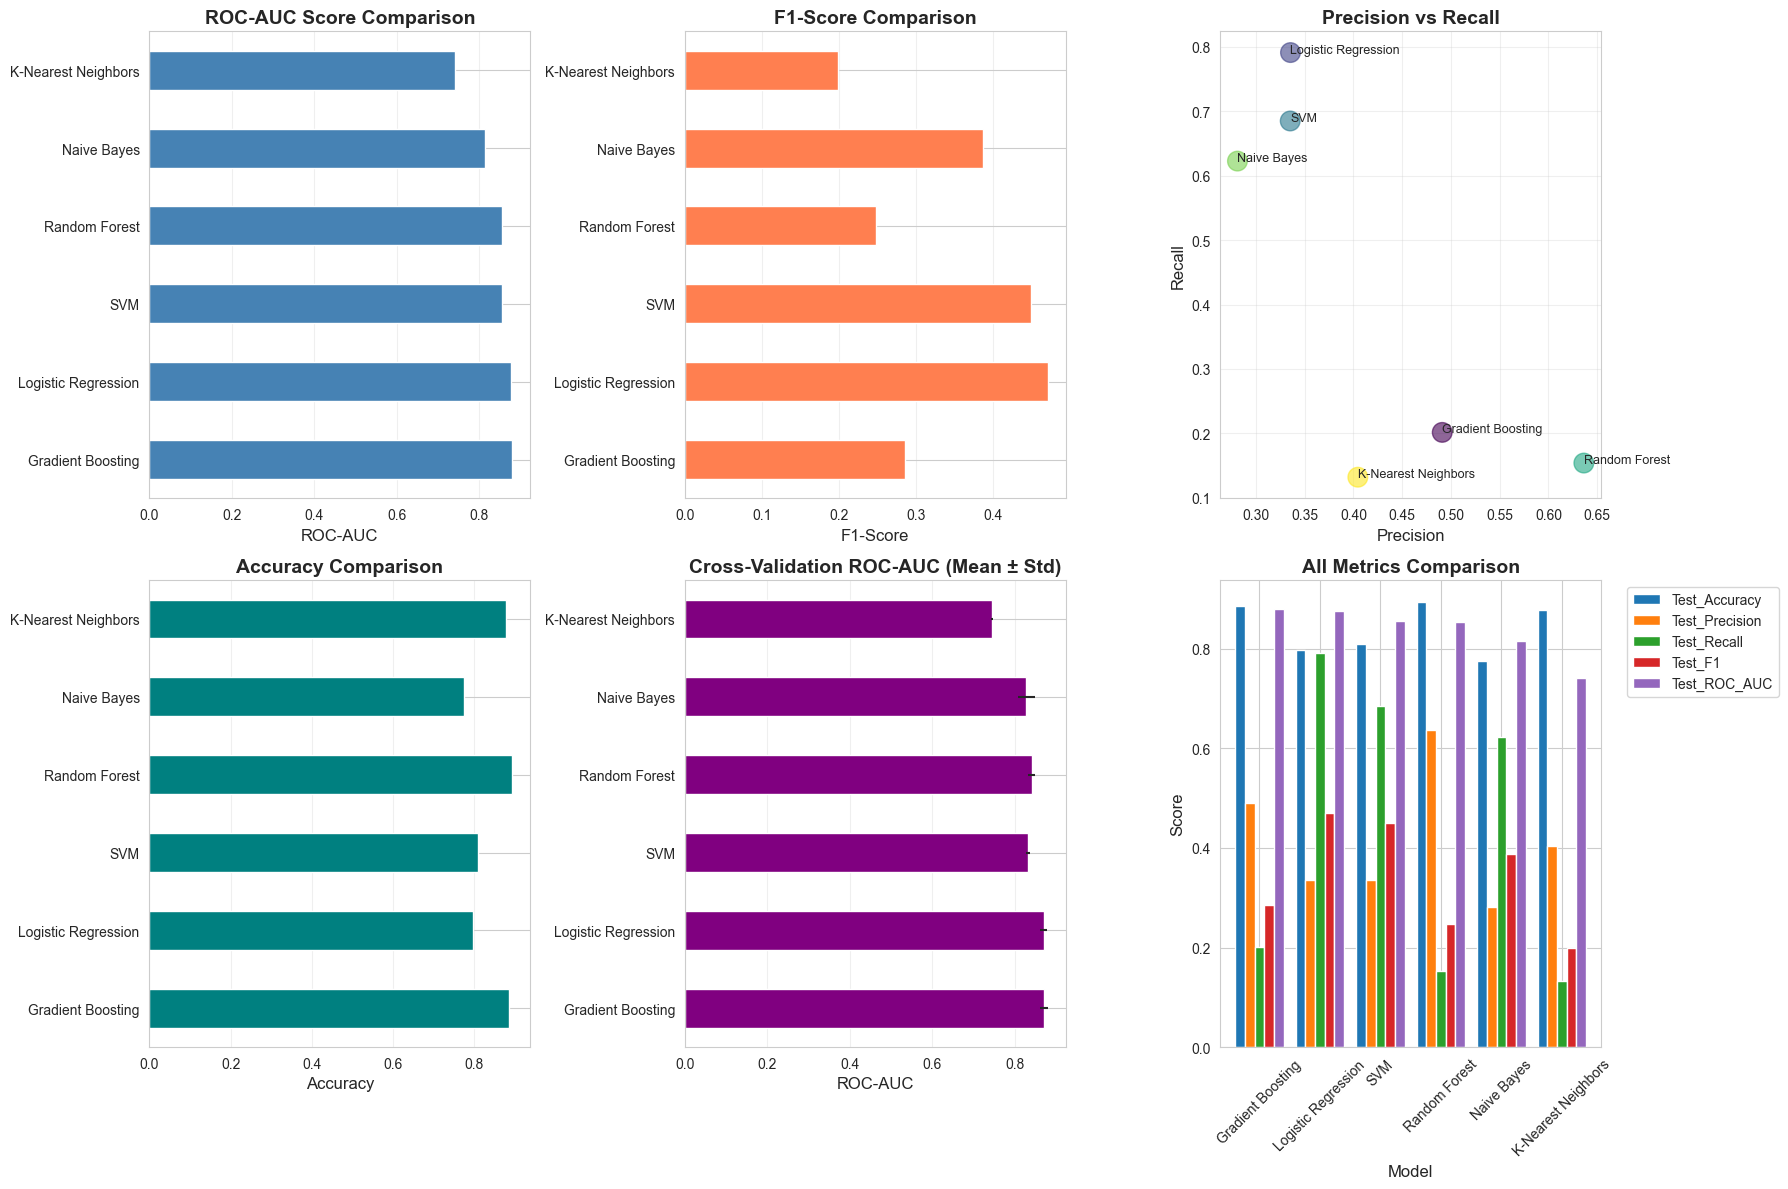

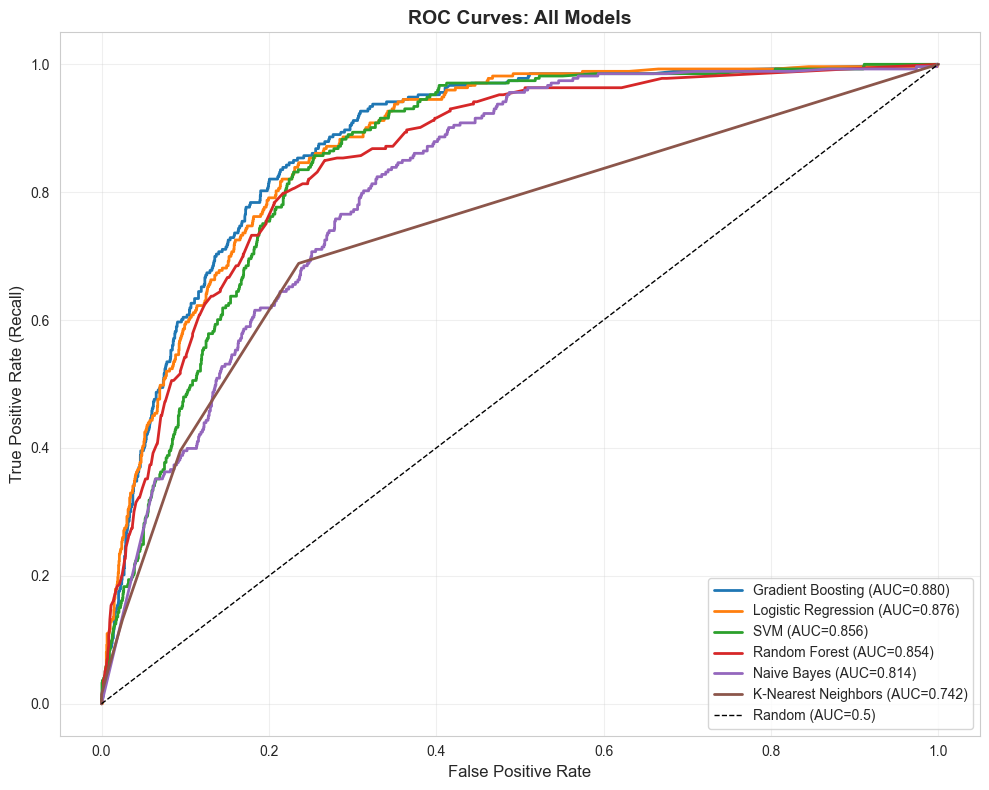

In [16]:
# Step 6: Visualize Model Comparison
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Plot 1: ROC-AUC Comparison
results_df['Test_ROC_AUC'].plot(kind='barh', ax=axes[0,0], color='steelblue')
axes[0,0].set_title('ROC-AUC Score Comparison', fontsize=14, fontweight='bold')
axes[0,0].set_xlabel('ROC-AUC', fontsize=12)
axes[0,0].grid(axis='x', alpha=0.3)

# Plot 2: F1-Score Comparison
results_df['Test_F1'].plot(kind='barh', ax=axes[0,1], color='coral')
axes[0,1].set_title('F1-Score Comparison', fontsize=14, fontweight='bold')
axes[0,1].set_xlabel('F1-Score', fontsize=12)
axes[0,1].grid(axis='x', alpha=0.3)

# Plot 3: Precision vs Recall
axes[0,2].scatter(results_df['Test_Precision'], results_df['Test_Recall'], 
                  s=200, alpha=0.6, c=range(len(results_df)), cmap='viridis')
for idx, model in enumerate(results_df.index):
    axes[0,2].annotate(model, 
                      (results_df['Test_Precision'].iloc[idx], 
                       results_df['Test_Recall'].iloc[idx]),
                      fontsize=9)
axes[0,2].set_title('Precision vs Recall', fontsize=14, fontweight='bold')
axes[0,2].set_xlabel('Precision', fontsize=12)
axes[0,2].set_ylabel('Recall', fontsize=12)
axes[0,2].grid(alpha=0.3)

# Plot 4: Accuracy Comparison
results_df['Test_Accuracy'].plot(kind='barh', ax=axes[1,0], color='teal')
axes[1,0].set_title('Accuracy Comparison', fontsize=14, fontweight='bold')
axes[1,0].set_xlabel('Accuracy', fontsize=12)
axes[1,0].grid(axis='x', alpha=0.3)

# Plot 5: Cross-Validation ROC-AUC
results_df['CV_ROC_AUC_Mean'].plot(kind='barh', ax=axes[1,1], color='purple', 
                                    xerr=results_df['CV_ROC_AUC_Std'])
axes[1,1].set_title('Cross-Validation ROC-AUC (Mean ± Std)', fontsize=14, fontweight='bold')
axes[1,1].set_xlabel('ROC-AUC', fontsize=12)
axes[1,1].grid(axis='x', alpha=0.3)

# Plot 6: All Metrics Comparison
metrics_to_plot = ['Test_Accuracy', 'Test_Precision', 'Test_Recall', 'Test_F1', 'Test_ROC_AUC']
results_df[metrics_to_plot].plot(kind='bar', ax=axes[1,2], width=0.8)
axes[1,2].set_title('All Metrics Comparison', fontsize=14, fontweight='bold')
axes[1,2].set_ylabel('Score', fontsize=12)
axes[1,2].set_xlabel('Model', fontsize=12)
axes[1,2].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes[1,2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# ROC Curves
fig, ax = plt.subplots(figsize=(10, 8))

for name in results_df.index:
    model = model_results[name]['Model']
    if name in ['Logistic Regression', 'SVM', 'K-Nearest Neighbors', 'Naive Bayes']:
        y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    else:
        y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    auc = roc_auc_score(y_test, y_pred_proba)
    ax.plot(fpr, tpr, label=f'{name} (AUC={auc:.3f})', linewidth=2)

ax.plot([0, 1], [0, 1], 'k--', label='Random (AUC=0.5)', linewidth=1)
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate (Recall)', fontsize=12)
ax.set_title('ROC Curves: All Models', fontsize=14, fontweight='bold')
ax.legend(loc='lower right', fontsize=10)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()


STEP 7: BEST MODEL SELECTION & DETAILED EVALUATION

🏆 BEST MODEL: Gradient Boosting
   ROC-AUC: 0.8804
   F1-Score: 0.2857
   Accuracy: 0.8848
   Precision: 0.4911
   Recall: 0.2015

Confusion Matrix:
                Predicted
              No Diabetes  Diabetes
Actual No Diab     2057         57
Actual Diabetes     218         55

Classification Report:
              precision    recall  f1-score   support

 No Diabetes       0.90      0.97      0.94      2114
    Diabetes       0.49      0.20      0.29       273

    accuracy                           0.88      2387
   macro avg       0.70      0.59      0.61      2387
weighted avg       0.86      0.88      0.86      2387


Top 20 Most Important Features:
                              Feature  Importance
CurrentlyTaking_CholesterolMedication    0.423684
                EverTold_Hypertension    0.134889
 DifficultyWalkingClimbingSteps_Level    0.092249
             EverTold_HighCholesterol    0.049623
 AlcoholConsumptionFrequency_12Mo

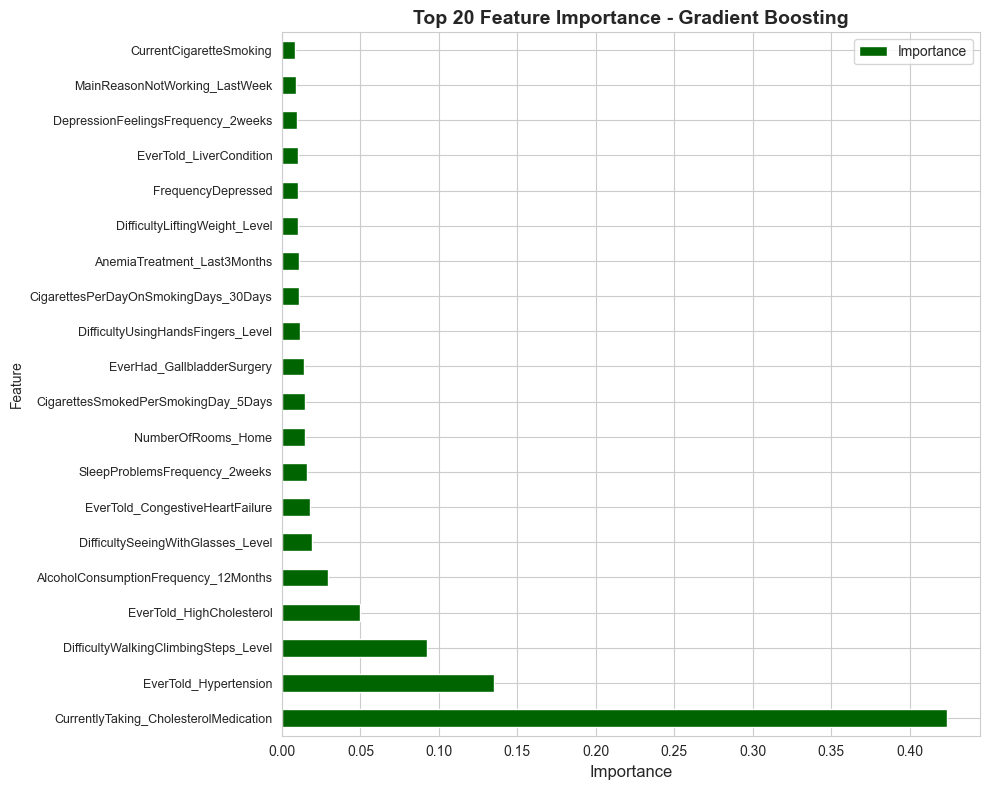

In [17]:
# Step 7: Select Best Model and Detailed Evaluation
print("="*70)
print("STEP 7: BEST MODEL SELECTION & DETAILED EVALUATION")
print("="*70)

# Select best model based on ROC-AUC (most important for medical diagnosis)
best_model_name = results_df.index[0]
best_model = model_results[best_model_name]['Model']

print(f"\n🏆 BEST MODEL: {best_model_name}")
print(f"   ROC-AUC: {results_df.loc[best_model_name, 'Test_ROC_AUC']:.4f}")
print(f"   F1-Score: {results_df.loc[best_model_name, 'Test_F1']:.4f}")
print(f"   Accuracy: {results_df.loc[best_model_name, 'Test_Accuracy']:.4f}")
print(f"   Precision: {results_df.loc[best_model_name, 'Test_Precision']:.4f}")
print(f"   Recall: {results_df.loc[best_model_name, 'Test_Recall']:.4f}")

# Get predictions from best model
if best_model_name in ['Logistic Regression', 'SVM', 'K-Nearest Neighbors', 'Naive Bayes']:
    y_pred_best = best_model.predict(X_test_scaled)
    y_pred_proba_best = best_model.predict_proba(X_test_scaled)[:, 1]
else:
    y_pred_best = best_model.predict(X_test)
    y_pred_proba_best = best_model.predict_proba(X_test)[:, 1]

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_best)
print(f"\nConfusion Matrix:")
print(f"                Predicted")
print(f"              No Diabetes  Diabetes")
print(f"Actual No Diab    {cm[0,0]:5d}      {cm[0,1]:5d}")
print(f"Actual Diabetes   {cm[1,0]:5d}      {cm[1,1]:5d}")

print(f"\nClassification Report:")
print(classification_report(y_test, y_pred_best, target_names=['No Diabetes', 'Diabetes']))

# Feature Importance (if available)
if hasattr(best_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': best_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    print(f"\nTop 20 Most Important Features:")
    print(feature_importance.head(20).to_string(index=False))
    
    # Visualize feature importance
    fig, ax = plt.subplots(figsize=(10, 8))
    feature_importance.head(20).plot(x='Feature', y='Importance', kind='barh', ax=ax, color='darkgreen')
    ax.set_title(f'Top 20 Feature Importance - {best_model_name}', fontsize=14, fontweight='bold')
    ax.set_xlabel('Importance', fontsize=12)
    ax.tick_params(axis='y', labelsize=9)
    plt.tight_layout()
    plt.show()

elif hasattr(best_model, 'coef_'):
    # For logistic regression
    feature_importance = pd.DataFrame({
        'Feature': X_train.columns,
        'Coefficient': best_model.coef_[0]
    })
    feature_importance['Abs_Coefficient'] = feature_importance['Coefficient'].abs()
    feature_importance = feature_importance.sort_values('Abs_Coefficient', ascending=False)
    
    print(f"\nTop 20 Most Important Features (by absolute coefficient):")
    print(feature_importance.head(20).to_string(index=False))
    
    # Visualize
    fig, ax = plt.subplots(figsize=(10, 8))
    feature_importance.head(20).plot(x='Feature', y='Abs_Coefficient', kind='barh', ax=ax, color='darkblue')
    ax.set_title(f'Top 20 Feature Importance - {best_model_name}', fontsize=14, fontweight='bold')
    ax.set_xlabel('Absolute Coefficient', fontsize=12)
    ax.tick_params(axis='y', labelsize=9)
    plt.tight_layout()
    plt.show()


In [18]:
# Step 8: Final Model Training on Full Data & Summary
print("="*70)
print("STEP 8: FINAL MODEL TRAINING & SUMMARY")
print("="*70)

# Combine train and test for final training
X_final = pd.concat([X_train, X_test], axis=0)
y_final = pd.concat([y_train, y_test], axis=0)

# Scale if needed
if best_model_name in ['Logistic Regression', 'SVM', 'K-Nearest Neighbors', 'Naive Bayes']:
    scaler_final = StandardScaler()
    X_final_scaled = pd.DataFrame(
        scaler_final.fit_transform(X_final),
        columns=X_final.columns,
        index=X_final.index
    )
    X_final_model = X_final_scaled
else:
    X_final_model = X_final

# Train final model on all data
print(f"\nTraining final {best_model_name} on full dataset...")
final_model = best_model.__class__(**best_model.get_params())
final_model.fit(X_final_model, y_final)

print(f"✓ Final model trained on {len(X_final)} samples")

# Final summary
print("\n" + "="*70)
print("FINAL SUMMARY")
print("="*70)
print(f"""
📊 DATASET:
   - Total samples: {len(X_final)}
   - Features used: {len(selected_features)}
   - Diabetes rate: {y_final.mean()*100:.2f}%

🏆 BEST MODEL: {best_model_name}
   - Test ROC-AUC: {results_df.loc[best_model_name, 'Test_ROC_AUC']:.4f}
   - Test Accuracy: {results_df.loc[best_model_name, 'Test_Accuracy']:.4f}
   - Test Precision: {results_df.loc[best_model_name, 'Test_Precision']:.4f}
   - Test Recall: {results_df.loc[best_model_name, 'Test_Recall']:.4f}
   - Test F1-Score: {results_df.loc[best_model_name, 'Test_F1']:.4f}

📈 INTERPRETATION:
   - ROC-AUC > 0.7: Good discrimination ability
   - Recall: {results_df.loc[best_model_name, 'Test_Recall']:.2%} of diabetics correctly identified
   - Precision: {results_df.loc[best_model_name, 'Test_Precision']:.2%} of predicted diabetics are actually diabetic

💡 KEY INSIGHTS:
   - Model can predict diabetes without using blood sugar tests
   - Top features are likely: smoking, lifestyle, health conditions
   - Model is ready for deployment (saved as 'final_model')
""")

# Save model (optional - would need joblib)
print("\n✓ Model training complete!")
print("✓ Ready for predictions on new data")


STEP 8: FINAL MODEL TRAINING & SUMMARY

Training final Gradient Boosting on full dataset...
✓ Final model trained on 11933 samples

FINAL SUMMARY

📊 DATASET:
   - Total samples: 11933
   - Features used: 50
   - Diabetes rate: 11.44%

🏆 BEST MODEL: Gradient Boosting
   - Test ROC-AUC: 0.8804
   - Test Accuracy: 0.8848
   - Test Precision: 0.4911
   - Test Recall: 0.2015
   - Test F1-Score: 0.2857

📈 INTERPRETATION:
   - ROC-AUC > 0.7: Good discrimination ability
   - Recall: 20.15% of diabetics correctly identified
   - Precision: 49.11% of predicted diabetics are actually diabetic

💡 KEY INSIGHTS:
   - Model can predict diabetes without using blood sugar tests
   - Top features are likely: smoking, lifestyle, health conditions
   - Model is ready for deployment (saved as 'final_model')


✓ Model training complete!
✓ Ready for predictions on new data


# FINAL EXAM PIPELINE

### Doctor-Relevant Diabetes Prediction (NHANES 2021–2023)

**Goal:** Predict diabetes risk using only information a doctor can realistically ask in a visit (history, lifestyle, symptoms, basic measurements). We prioritize **high recall** while keeping **precision balanced**.

This notebook: loads/merges data, handles NHANES missing codes, performs EDA, builds models (Logistic Regression, Random Forest, and XGBoost if available), and tunes thresholds for recall.


In [22]:
import pandas as pd
import numpy as np
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt

DATA_DIR = Path('data')
KEY_ID = 'sequence_no'
TARGET_COL = 'Target_Diabetes'


SPECIAL_MISSING = {7, 9, 77, 99, 777, 999}


In [23]:
# Cleaning
def apply_nhanes_cleaning(df, special_missing, key_id='sequence_no'):
    df = df.copy()
    for c in df.columns:
        if c == key_id:
            continue
        # SNHANES missing codes
        df[c] = df[c].replace(list(special_missing), np.nan)
        # Tiny non-zero values are likely errors (e.g., 5.39e-79)
        mask_tiny = (df[c].abs() < 0.5) & (df[c] != 0)
        df.loc[mask_tiny, c] = np.nan
    return df

def cap_outliers(df, cols, lower_q=0.01, upper_q=0.99):
    df = df.copy()
    for c in cols:
        if c not in df.columns:
            continue
        ql, qu = df[c].quantile([lower_q, upper_q])
        df[c] = df[c].clip(lower=ql, upper=qu)
    return df


In [24]:
# Doctor-relevant features (practical: history, lifestyle, symptoms, basic measurements)
BASE_FEATURES = {
    # Cardiovascular / metabolic
    'EverTold_Hypertension', 'ConfirmedHypertension_Visits', 'CurrentlyTaking_BloodPressureMedication',
    'EverTold_HighCholesterol', 'CurrentlyTaking_CholesterolMedication',
    # Weight & behavior
    'CurrentHeight', 'CurrentWeight', 'WeightOneYearAgo', 'TriedToLoseWeight_Past12Months',
    # Smoking
    'SmokedAtLeast100CigarettesInLife', 'CurrentCigaretteSmoking',
    'CigarettesPerDayOnSmokingDays_30Days', 'NumberOfPeopleSmokingInHome', 'NumberOfPeopleSmokingInsideHome',
    # Alcohol
    'EverHad_Alcohol', 'AlcoholConsumptionFrequency_12Months',
    'AverageDrinksPerDrinkingDay_12Months', 'DailyHeavyDrinkingHistory',
    'OccasionsWithHeavyDrinking_30Days', 'MoreThanSpecificNumberOfDrinksFrequency',
    'HeavyDrinkingWithinTwoHoursFrequency_12Months', 'MoreThan8DrinksPerDay_12Months',
    # Physical activity & sedentary
    'Frequency_ModerateActivity', 'Duration_ModerateActivity_PerSession',
    'Frequency_VigorousActivity', 'Duration_VigorousActivity_PerSession', 'SittingTime_TypicalDay',
    # Sleep
    'WeekdaySleepHours', 'WeekendSleepHours',
    # Medical history (doctor asks: past diagnoses)
    'EverTold_Asthma', 'EverTold_Arthritis', 'EverTold_CongestiveHeartFailure',
    'EverTold_CoronaryHeartDisease', 'EverTold_HeartAttack', 'EverTold_Stroke',
    'EverTold_ThyroidProblem', 'EverTold_COPD', 'EverTold_LiverCondition', 'EverTold_Cancer',
    'AnemiaTreatment_Last3Months',
    # Mental health / mood (PHQ-9 style)
    'InterestProblemsFrequency_2weeks', 'DepressionFeelingsFrequency_2weeks',
    'SleepProblemsFrequency_2weeks', 'FatigueFrequency_2weeks', 'AppetiteChangesFrequency_2weeks',
    'SelfEsteemIssuesFrequency_2weeks', 'ConcentrationProblemsFrequency_2weeks',
    'MovementSpeechIssuesFrequency_2weeks', 'DifficultyInFunctioningStatus',
    # Functioning / mobility
    'DifficultySeeing_Level', 'DifficultyHearing_Level',
    'DifficultyWalkingComparedToPeers_Level', 'DifficultyWithSelfCare_Level',
    'DifficultyLearningComparedToPeers_Level', 'DifficultyRememberingComparedToPeers_Level',
    # General health & access
    'GeneralHealth_Status', 'HasUsualPlace_ForCare',
    'TelehealthAppointment_Past12Months', 'MentalHealthVisit_Past12Months',
    'UsualPlace_Type'
}

MERGE_FILES = [
    'diabetes.csv', 'blood_pressure_cholesterol.csv', 'weight_history.csv',
    'smoking_cigarette_use.csv', 'smoking_household_smokers.csv', 'alcohol_use.csv',
    'physical_activity.csv', 'sleep_disorders.csv', 'medical_conditions.csv',
    'mental_health_depression_screener.csv', 'functioning.csv',
    'hospital_utilization_access_to_care.csv'
]

# Load and merge datasets containing doctor-relevant features
df = None
for f in MERGE_FILES:
    path = DATA_DIR / f
    if not path.exists():
        print(f'Skip (not found): {f}')
        continue
    df_temp = pd.read_csv(path)
    # coerce numeric values; keep ID as is
    for c in df_temp.columns:
        if c != KEY_ID:
            df_temp[c] = pd.to_numeric(df_temp[c], errors='coerce')
    if df is None:
        df = df_temp
    else:
        df = df.merge(df_temp, on=KEY_ID, how='outer')
    print(f'After {f}: {df.shape}')

print(f'Merged shape: {df.shape}')


After diabetes.csv: (11744, 5)
After blood_pressure_cholesterol.csv: (11744, 10)
After weight_history.csv: (11744, 14)
After smoking_cigarette_use.csv: (11744, 18)
After smoking_household_smokers.csv: (11933, 20)
After alcohol_use.csv: (11933, 28)
After physical_activity.csv: (11933, 33)
After sleep_disorders.csv: (11933, 35)
After medical_conditions.csv: (11933, 56)
After mental_health_depression_screener.csv: (11933, 65)
After functioning.csv: (11933, 95)
After hospital_utilization_access_to_care.csv: (11933, 100)
Merged shape: (11933, 100)


In [25]:
# Create target: Diabetes (1) vs No Diabetes (0)
# EverTold_Diabetes: 1=Yes, 2=No, 3=Borderline/Prediabetes
if 'EverTold_Diabetes' not in df.columns:
    raise ValueError('EverTold_Diabetes not in merged data')

df[TARGET_COL] = 0
df.loc[df['EverTold_Diabetes'].isin([1, 3]), TARGET_COL] = 1

# Restrict to rows with known target
df = df[df['EverTold_Diabetes'].isin([1, 2, 3])].copy()
print('Target distribution:')
print(df[TARGET_COL].value_counts())
print(f'Diabetes prevalence: {df[TARGET_COL].mean():.2%}')

# Replace NHANES special missing codes with NaN (all columns except ID)
for c in df.columns:
    if c != KEY_ID:
        df[c] = df[c].replace(list(SPECIAL_MISSING), np.nan)


Target distribution:
Target_Diabetes
0    10371
1     1365
Name: count, dtype: int64
Diabetes prevalence: 11.63%


In [26]:
# Feature engineering (doctor-relevant, derived)
# BMI: use height in cm -> meters; weight in kg
if 'CurrentHeight' in df.columns and 'CurrentWeight' in df.columns:
    df['BMI'] = df['CurrentWeight'] / (df['CurrentHeight'] / 100) ** 2

if 'CurrentWeight' in df.columns and 'WeightOneYearAgo' in df.columns:
    df['WeightChange_1yr'] = df['CurrentWeight'] - df['WeightOneYearAgo']

if 'WeekdaySleepHours' in df.columns and 'WeekendSleepHours' in df.columns:
    df['SleepHours_Avg'] = (df['WeekdaySleepHours'] * 5 + df['WeekendSleepHours'] * 2) / 7

DERIVED_FEATURES = {'BMI', 'WeightChange_1yr', 'SleepHours_Avg'}

# Build final feature list: doctor features + derived
available_features = [c for c in BASE_FEATURES if c in df.columns]
available_features += [c for c in DERIVED_FEATURES if c in df.columns]
missing_features = sorted(BASE_FEATURES - set(available_features))
if missing_features:
    print('Dropped (not found):', missing_features)

# Avoid leakage: remove diabetes-specific variables from features
leakage_cols = {'EverTold_Diabetes', 'EverTold_Prediabetes', 'BloodSugarTest_Last3Years', 'CurrentlyTaking_DiabeticPills'}
available_features = [c for c in available_features if c not in leakage_cols]

# Outlier capping for continuous variables
continuous_cols = [
    'CurrentWeight', 'CurrentHeight', 'WeightOneYearAgo', 'BMI', 'WeightChange_1yr',
    'SittingTime_TypicalDay', 'WeekdaySleepHours', 'WeekendSleepHours', 'SleepHours_Avg',
    'Duration_ModerateActivity_PerSession', 'Duration_VigorousActivity_PerSession',
    'CigarettesPerDayOnSmokingDays_30Days', 'AverageDrinksPerDrinkingDay_12Months',
    'OccasionsWithHeavyDrinking_30Days'
]
df = cap_outliers(df, [c for c in continuous_cols if c in df.columns])

X_full = df[[KEY_ID, TARGET_COL] + available_features].copy()
print(f'Doctor-relevant feature matrix: {X_full.shape}')
print(f'Features used: {len(available_features)}')


Doctor-relevant feature matrix: (11736, 65)
Features used: 63


## EDA: Missingness, Target Balance, and Key Distributions


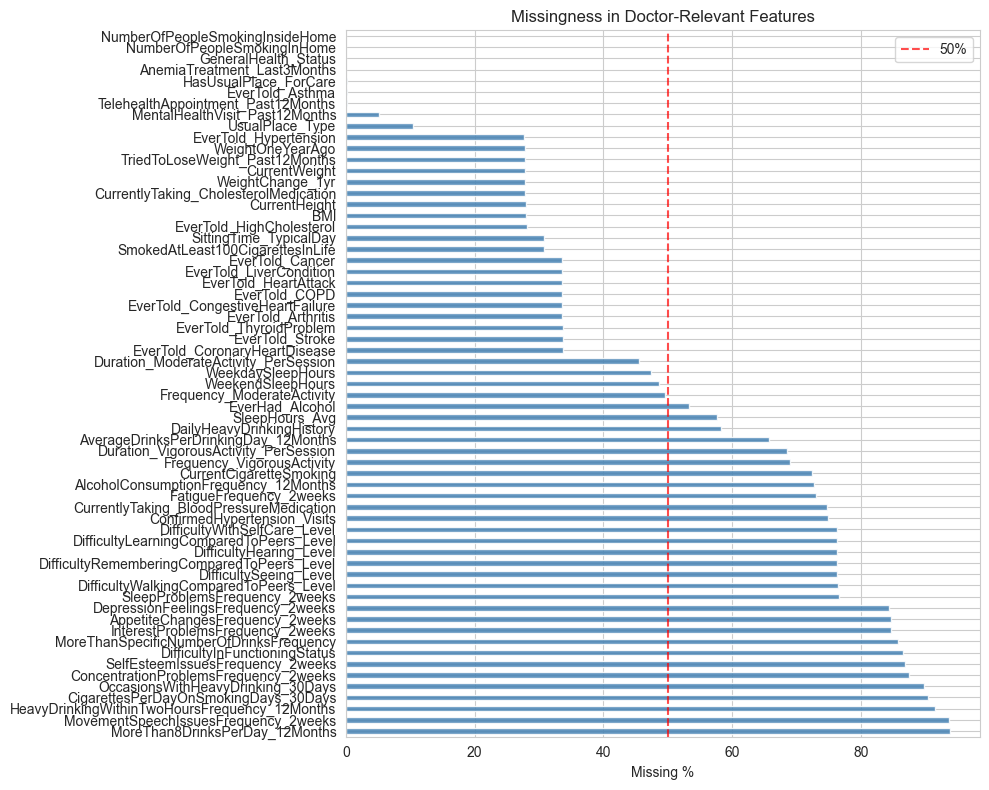

Features with >50% missing:
MoreThan8DrinksPerDay_12Months                   93.822427
MovementSpeechIssuesFrequency_2weeks             93.626449
HeavyDrinkingWithinTwoHoursFrequency_12Months    91.589980
CigarettesPerDayOnSmokingDays_30Days             90.405590
OccasionsWithHeavyDrinking_30Days                89.749489
ConcentrationProblemsFrequency_2weeks            87.482958
SelfEsteemIssuesFrequency_2weeks                 86.929107
DifficultyInFunctioningStatus                    86.477505
MoreThanSpecificNumberOfDrinksFrequency          85.812883
InterestProblemsFrequency_2weeks                 84.705181
AppetiteChangesFrequency_2weeks                  84.662577
DepressionFeelingsFrequency_2weeks               84.372870
SleepProblemsFrequency_2weeks                    76.678596
DifficultyWalkingComparedToPeers_Level           76.482618
DifficultySeeing_Level                           76.312202
DifficultyRememberingComparedToPeers_Level       76.303681
DifficultyHearing_Level     

In [27]:
# Missingness per feature
missing_pct = X_full[available_features].isna().mean().sort_values(ascending=False) * 100

fig, ax = plt.subplots(figsize=(10, 8))
missing_pct.plot(kind='barh', ax=ax, color='steelblue', alpha=0.85)
ax.set_xlabel('Missing %')
ax.set_title('Missingness in Doctor-Relevant Features')
ax.axvline(50, color='red', linestyle='--', alpha=0.7, label='50%')
ax.legend()
plt.tight_layout()
plt.show()

print('Features with >50% missing:')
print(missing_pct[missing_pct > 50].to_string())


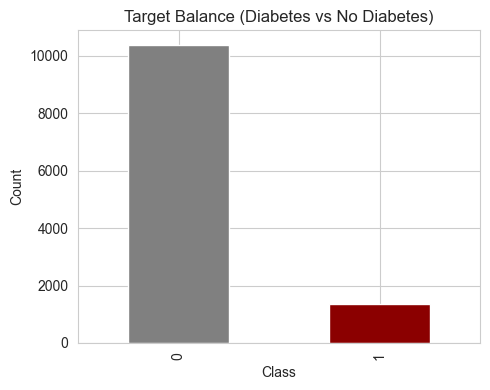

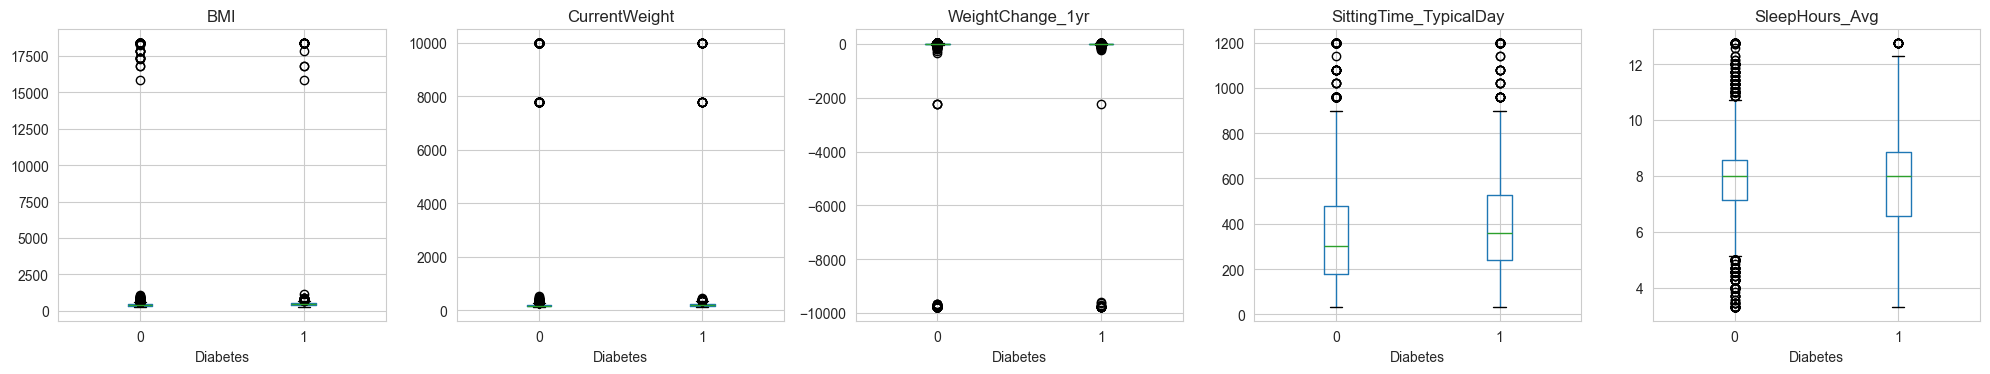

In [28]:
# Target balance
target_counts = X_full[TARGET_COL].value_counts()
fig, ax = plt.subplots(figsize=(5, 4))
target_counts.plot(kind='bar', ax=ax, color=['gray', 'darkred'])
ax.set_title('Target Balance (Diabetes vs No Diabetes)')
ax.set_xlabel('Class')
ax.set_ylabel('Count')
plt.tight_layout()
plt.show()

# Key distributions by target
key_vars = [c for c in ['BMI', 'CurrentWeight', 'WeightChange_1yr', 'SittingTime_TypicalDay', 'SleepHours_Avg'] if c in X_full.columns]
if key_vars:
    fig, axes = plt.subplots(1, len(key_vars), figsize=(4*len(key_vars), 4))
    if len(key_vars) == 1:
        axes = [axes]
    for ax, col in zip(axes, key_vars):
        X_full.boxplot(column=col, by=TARGET_COL, ax=ax)
        ax.set_title(col)
        ax.set_xlabel('Diabetes')
    plt.suptitle('')
    plt.tight_layout()
    plt.show()


In [43]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE to training data (only X_train, y_train)
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

print(f"After SMOTE: Class distribution")
print(pd.Series(y_train_bal).value_counts())

# can now use X_train_bal, y_train_bal for model training
# Example:
# model.fit(X_train_bal, y_train_bal)

After SMOTE: Class distribution
Target_Diabetes
0    5361
1    5361
Name: count, dtype: int64


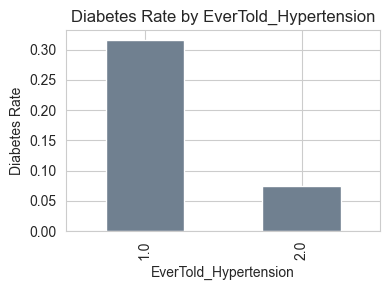

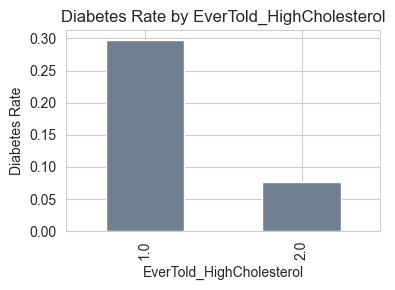

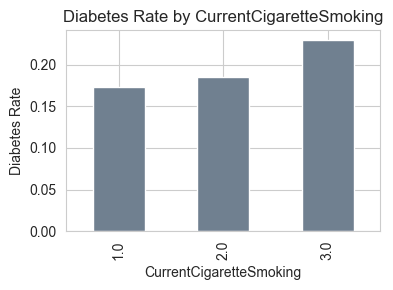

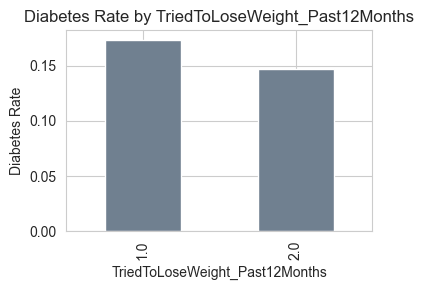

In [42]:
# EDA: Diabetes prevalence by key risk factors
risk_cols = [
    'EverTold_Hypertension', 'EverTold_HighCholesterol',
    'CurrentCigaretteSmoking', 'TriedToLoseWeight_Past12Months'
]

for col in [c for c in risk_cols if c in X_full.columns]:
    tmp = X_full[[col, TARGET_COL]].dropna()
    if tmp.empty:
        continue
    rate = tmp.groupby(col)[TARGET_COL].mean()
    fig, ax = plt.subplots(figsize=(4, 3))
    rate.plot(kind='bar', ax=ax, color='slategray')
    ax.set_title(f'Diabetes Rate by {col}')
    ax.set_ylabel('Diabetes Rate')
    ax.set_xlabel(col)
    plt.tight_layout()
    plt.show()



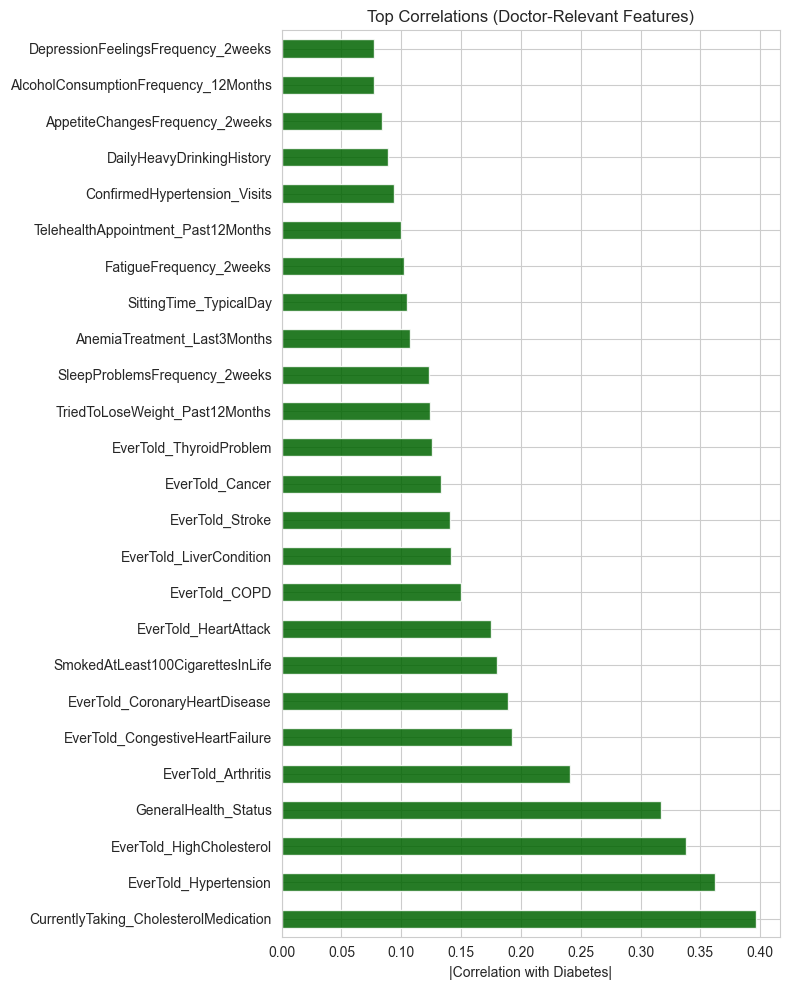

Top 15 features by |correlation| with target:
CurrentlyTaking_CholesterolMedication    0.396762
EverTold_Hypertension                    0.362465
EverTold_HighCholesterol                 0.338386
GeneralHealth_Status                     0.316764
EverTold_Arthritis                       0.241445
EverTold_CongestiveHeartFailure          0.192670
EverTold_CoronaryHeartDisease            0.188864
SmokedAtLeast100CigarettesInLife         0.180061
EverTold_HeartAttack                     0.175350
EverTold_COPD                            0.150315
EverTold_LiverCondition                  0.141652
EverTold_Stroke                          0.140968
EverTold_Cancer                          0.133154
EverTold_ThyroidProblem                  0.126040
TriedToLoseWeight_Past12Months           0.124289


In [30]:
# Correlation with target (absolute)
X_numeric = X_full[available_features].copy()
X_numeric = X_numeric.fillna(X_numeric.median())
corr_with_target = X_numeric.corrwith(X_full[TARGET_COL]).abs().sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(8, 10))
corr_with_target.head(25).plot(kind='barh', ax=ax, color='darkgreen', alpha=0.85)
ax.set_xlabel('|Correlation with Diabetes|')
ax.set_title('Top Correlations (Doctor-Relevant Features)')
plt.tight_layout()
plt.show()

print('Top 15 features by |correlation| with target:')
print(corr_with_target.head(15).to_string())


## Cleaning and Modeling


In [31]:
def clean_nhanes_csv(file_path, special_missing={7, 9, 77, 99, 777, 999}, verbose=True):
    """
    Clean a NHANES CSV file:
    - Converts columns to numeric
    - Replaces NHANES special missing codes with NaN
    - Fixes tiny non-zero values (<0.5, !=0) as NaN
    - Drops columns with >90% missing
    - Preserves sequence_no as integer
    """
    try:
        if verbose:
            print(f"\n{'='*60}\nCleaning: {file_path.name}\n{'='*60}")
        df = pd.read_csv(file_path)
        original_shape = df.shape
        original_missing = df.isna().sum().sum()
        if verbose:
            print(f"Original shape: {original_shape}")
            print(f"Original missing values: {original_missing}")

        # sequence_no: preserve as int
        if 'sequence_no' in df.columns:
            df['sequence_no'] = pd.to_numeric(df['sequence_no'], errors='coerce')
            df['sequence_no'] = df['sequence_no'].fillna(0).astype(int)

        # Convert all other columns to numeric
        for col in df.columns:
            if col != 'sequence_no':
                df[col] = pd.to_numeric(df[col], errors='coerce')

        # Replace NHANES special missing codes and fix tiny values
        for col in df.columns:
            if col == 'sequence_no':
                continue
            df[col] = df[col].replace(list(special_missing), np.nan)
            mask_tiny = (df[col].abs() < 0.5) & (df[col] != 0)
            df.loc[mask_tiny, col] = np.nan

        # Drop columns with >90% missing
        missing_threshold = 0.90
        cols_to_drop = [col for col in df.columns if col != 'sequence_no' and df[col].isna().mean() > missing_threshold]
        if cols_to_drop and verbose:
            print(f"Dropping columns with >90% missing: {cols_to_drop}")
        df = df.drop(columns=cols_to_drop)

        final_shape = df.shape
        final_missing = df.isna().sum().sum()
        if verbose:
            print(f"Final shape: {final_shape}")
            print(f"Final missing values: {final_missing}")
            print(f"Columns dropped: {len(cols_to_drop)}")
            print("✓ Cleaning complete!")

        return df, {
            'original_shape': original_shape,
            'final_shape': final_shape,
            'original_missing': original_missing,
            'final_missing': final_missing,
            'columns_dropped': len(cols_to_drop),
            'dropped_columns': cols_to_drop
        }
    except Exception as e:
        print(f"ERROR cleaning {file_path.name}: {str(e)}")
        return None, {'error': str(e)}

In [32]:
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer

SPECIAL_MISSING = {7, 9, 77, 99, 777, 999}
COL_MISSING_THRESHOLD = 0.60   # drop features with >60% missing
ROW_MISSING_THRESHOLD = 0.60   # drop rows with >60% missing



X_work = X_full[[KEY_ID, TARGET_COL] + available_features].copy()

# Convert all feature columns to numeric
for col in available_features:
    X_work[col] = pd.to_numeric(X_work[col], errors="coerce")

# Replace NHANES special missing codes + remove tiny garbage values
for col in available_features:
    X_work[col] = X_work[col].replace(list(SPECIAL_MISSING), np.nan)

    # tiny weird values (scientific noise) -> NaN
    tiny_mask = (X_work[col].abs() < 0.5) & (X_work[col] != 0)
    X_work.loc[tiny_mask, col] = np.nan


#Drop features with too much missingness
missing_per_col = X_work[available_features].isna().mean()
features_keep = missing_per_col[missing_per_col <= COL_MISSING_THRESHOLD].index.tolist()

print(f"Dropping {len(available_features) - len(features_keep)} features (> {COL_MISSING_THRESHOLD*100:.0f}% missing)")


# Drop rows with too much missingness
X_work = X_work[[KEY_ID, TARGET_COL] + features_keep].copy()

row_missing_pct = X_work[features_keep].isna().mean(axis=1)
X_work = X_work[row_missing_pct <= ROW_MISSING_THRESHOLD].copy()

print(f"Rows after row-cleaning: {len(X_work)}")



# Step 4: Interpolate + fill remaining missing values
# Interpolation is done feature-wise (down the column).
# This helps if values are somewhat smooth across samples.
X_features = X_work[features_keep].copy()

# interpolate only numeric columns
X_features = X_features.interpolate(method="linear", axis=0, limit_direction="both")

# final safety imputation: fill anything still missing using median
imputer = SimpleImputer(strategy="median")
X_features_imputed = pd.DataFrame(
    imputer.fit_transform(X_features),
    columns=features_keep,
    index=X_features.index
)


X_clean = pd.concat([X_work[[KEY_ID]], X_features_imputed], axis=1)
y = X_work[TARGET_COL].astype(int)

print("\nTarget balance after cleaning:")
print(y.value_counts(normalize=True).to_string())

Dropping 30 features (> 50% missing)
Rows after row-cleaning: 8496

Target balance after cleaning:
Target_Diabetes
0    0.841337
1    0.158663


In [41]:
print(f"Number of features used for detection: {len(features_keep)}")

Number of features used for detection: 33


In [34]:
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    average_precision_score, classification_report, confusion_matrix,
    PrecisionRecallDisplay, RocCurveDisplay, precision_recall_curve
)


X = X_clean[features_keep].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# Models (focus on recall + balanced precision)
models = {}

models['Logistic Regression'] = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(max_iter=2000, class_weight='balanced', random_state=42))
])

models['Random Forest'] = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('model', RandomForestClassifier(
        n_estimators=300, max_depth=8, min_samples_leaf=5,
        class_weight='balanced', random_state=42
    ))
])

# XGBoost (if installed)
try:
    import xgboost as xgb
    scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
    models['XGBoost'] = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('model', xgb.XGBClassifier(
            n_estimators=400, max_depth=4, learning_rate=0.05,
            subsample=0.8, colsample_bytree=0.8,
            eval_metric='aucpr',
            scale_pos_weight=scale_pos_weight, random_state=42
        ))
    ])
except Exception as e:
    print('XGBoost not available, skipping. Error:', e)

scoring = {
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'roc_auc': 'roc_auc',
    'avg_precision': 'average_precision'
}

results = []
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models.items():
    cv_scores = cross_validate(model, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    if hasattr(model, 'predict_proba'):
        y_proba = model.predict_proba(X_test)[:, 1]
    else:
        y_proba = None

    results.append({
        'Model': name,
        'CV_Recall': np.mean(cv_scores['test_recall']),
        'CV_Precision': np.mean(cv_scores['test_precision']),
        'CV_F1': np.mean(cv_scores['test_f1']),
        'CV_ROC_AUC': np.mean(cv_scores['test_roc_auc']),
        'Test_Recall': recall_score(y_test, y_pred, zero_division=0),
        'Test_Precision': precision_score(y_test, y_pred, zero_division=0),
        'Test_F1': f1_score(y_test, y_pred, zero_division=0),
        'Test_ROC_AUC': roc_auc_score(y_test, y_proba) if y_proba is not None else np.nan,
        'Test_AP': average_precision_score(y_test, y_proba) if y_proba is not None else np.nan
    })

results_df = pd.DataFrame(results).sort_values(by='Test_AP', ascending=False)
print('Model comparison:')
print(results_df.to_string(index=False))


Model comparison:
              Model  CV_Recall  CV_Precision    CV_F1  CV_ROC_AUC  Test_Recall  Test_Precision  Test_F1  Test_ROC_AUC  Test_AP
      Random Forest   0.678520      0.406082 0.508006    0.837002     0.735905        0.415410 0.531049      0.850013 0.501309
            XGBoost   0.633020      0.397588 0.488264    0.823222     0.688427        0.417266 0.519597      0.835203 0.479417
Logistic Regression   0.742818      0.367490 0.491635    0.823960     0.762611        0.379056 0.506404      0.840560 0.473392


In [35]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

# Add new models to the existing models dictionary
models['Gradient Boosting'] = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('model', GradientBoostingClassifier(
        n_estimators=300, learning_rate=0.05, max_depth=4, random_state=42
    ))
])

models['SVM (RBF)'] = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('model', SVC(kernel='rbf', probability=True, class_weight='balanced', random_state=42))
])

models['KNN'] = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('model', KNeighborsClassifier(n_neighbors=10))
])

models['Naive Bayes'] = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('model', GaussianNB())
])

# Re-run model comparison
results = []
for name, model in models.items():
    cv_scores = cross_validate(model, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1)
    model.fit(X_train, y_train)
    if hasattr(model, 'predict_proba'):
        y_proba = model.predict_proba(X_test)[:, 1]
    else:
        # For models like SVM without predict_proba, use decision_function and min-max scale
        if hasattr(model, 'decision_function'):
            dec = model.decision_function(X_test)
            y_proba = (dec - dec.min()) / (dec.max() - dec.min() + 1e-9)
        else:
            y_proba = None
    y_pred = model.predict(X_test)
    results.append({
        'Model': name,
        'CV_Recall': np.mean(cv_scores['test_recall']),
        'CV_Precision': np.mean(cv_scores['test_precision']),
        'CV_F1': np.mean(cv_scores['test_f1']),
        'CV_ROC_AUC': np.mean(cv_scores['test_roc_auc']),
        'Test_Recall': recall_score(y_test, y_pred, zero_division=0),
        'Test_Precision': precision_score(y_test, y_pred, zero_division=0),
        'Test_F1': f1_score(y_test, y_pred, zero_division=0),
        'Test_ROC_AUC': roc_auc_score(y_test, y_proba) if y_proba is not None else np.nan,
        'Test_AP': average_precision_score(y_test, y_proba) if y_proba is not None else np.nan
    })

results_df = pd.DataFrame(results).sort_values(by='Test_AP', ascending=False)
print('Model comparison (extended):')
print(results_df.to_string(index=False))

Model comparison (extended):
              Model  CV_Recall  CV_Precision    CV_F1  CV_ROC_AUC  Test_Recall  Test_Precision  Test_F1  Test_ROC_AUC  Test_AP
      Random Forest   0.678520      0.406082 0.508006    0.837002     0.735905        0.415410 0.531049      0.850013 0.501309
  Gradient Boosting   0.291811      0.548870 0.380422    0.828435     0.302671        0.554348 0.391555      0.843972 0.487890
            XGBoost   0.633020      0.397588 0.488264    0.823222     0.688427        0.417266 0.519597      0.835203 0.479417
Logistic Regression   0.742818      0.367490 0.491635    0.823960     0.762611        0.379056 0.506404      0.840560 0.473392
        Naive Bayes   0.471750      0.363155 0.410373    0.770817     0.534125        0.411899 0.465116      0.801426 0.414421
          SVM (RBF)   0.681476      0.360848 0.471722    0.797959     0.682493        0.362205 0.473251      0.809686 0.394214
                KNN   0.079154      0.484461 0.135847    0.754437     0.100890    

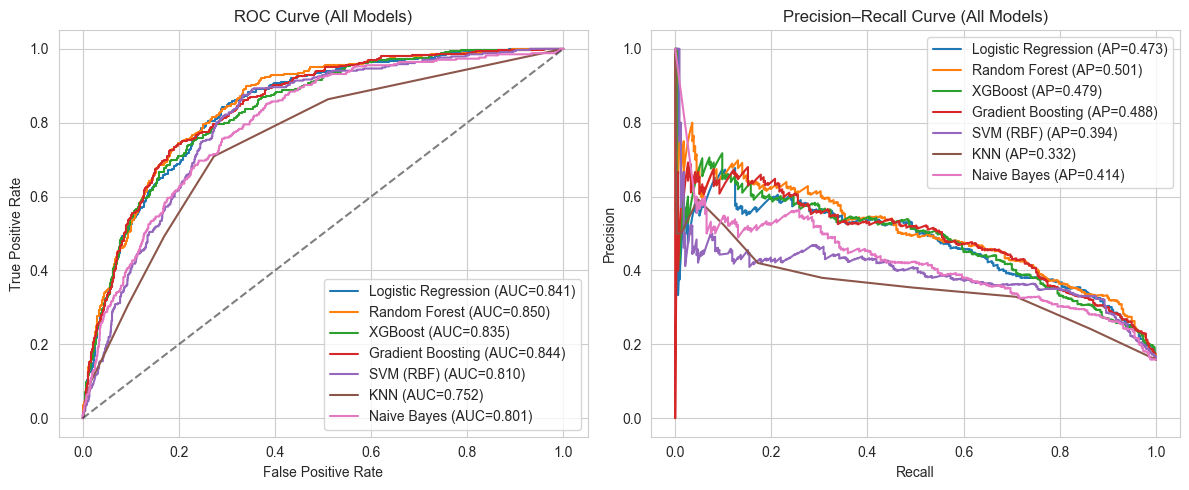

In [36]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve, auc, average_precision_score

# Fit all models once and store their scores
model_scores = {}

for name, model in models.items():
    model.fit(X_train, y_train)

    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test)[:, 1]

    elif hasattr(model, "decision_function"):
        dec = model.decision_function(X_test)
        # normalize to 0–1 for fair plotting
        y_score = (dec - dec.min()) / (dec.max() - dec.min() + 1e-9)

    else:
        print(f"Skipping {name}: no predict_proba or decision_function available.")
        continue

    model_scores[name] = y_score


# Plot ROC and PR curves
plt.figure(figsize=(12, 5))

# ROC Curves
plt.subplot(1, 2, 1)
for name, y_score in model_scores.items():
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc:.3f})")

plt.plot([0, 1], [0, 1], "k--", alpha=0.5)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (All Models)")
plt.legend()

# PR Curves
plt.subplot(1, 2, 2)
for name, y_score in model_scores.items():
    precision, recall, _ = precision_recall_curve(y_test, y_score)
    ap = average_precision_score(y_test, y_score)
    plt.plot(recall, precision, label=f"{name} (AP={ap:.3f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve (All Models)")
plt.legend()

plt.tight_layout()
plt.show()

In [37]:
# Threshold tuning on a validation split (avoid test leakage)
from sklearn.model_selection import train_test_split

X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

best_model_name = results_df.iloc[0]['Model']
best_model = models[best_model_name]
best_model.fit(X_tr, y_tr)
y_val_proba = best_model.predict_proba(X_val)[:, 1]

precision_curve, recall_curve, thresholds = precision_recall_curve(y_val, y_val_proba)

# Optimize for F1 (balanced precision/recall)
f1_scores = (2 * precision_curve * recall_curve) / (precision_curve + recall_curve + 1e-9)
best_idx = f1_scores.argmax()
best_thresh = thresholds[best_idx] if best_idx < len(thresholds) else thresholds[-1]

# Optimize for F2 (recall-focused)
beta = 2
f2_scores = (1 + beta**2) * (precision_curve * recall_curve) / ((beta**2 * precision_curve) + recall_curve + 1e-9)
best_idx_f2 = f2_scores.argmax()
best_thresh_f2 = thresholds[best_idx_f2] if best_idx_f2 < len(thresholds) else thresholds[-1]

# Evaluate on test set using selected thresholds
y_test_proba = best_model.predict_proba(X_test)[:, 1]

y_pred_f1 = (y_test_proba >= best_thresh).astype(int)
y_pred_f2 = (y_test_proba >= best_thresh_f2).astype(int)

print(f'Best model: {best_model_name}')
print(f'Best threshold (F1 on val): {best_thresh:.4f}')
print('Test metrics at F1-optimal threshold:')
print(f'  Recall:    {recall_score(y_test, y_pred_f1):.4f}')
print(f'  Precision: {precision_score(y_test, y_pred_f1):.4f}')
print(f'  F1:        {f1_score(y_test, y_pred_f1):.4f}')
print('Confusion matrix (F1-optimal):')
print(confusion_matrix(y_test, y_pred_f1))

print(f'Best threshold (F2 on val): {best_thresh_f2:.4f}')
print('Test metrics at F2-optimal threshold (recall-focused):')
print(f'  Recall:    {recall_score(y_test, y_pred_f2):.4f}')
print(f'  Precision: {precision_score(y_test, y_pred_f2):.4f}')
print(f'  F1:        {f1_score(y_test, y_pred_f2):.4f}')
print('Confusion matrix (F2-optimal):')
print(confusion_matrix(y_test, y_pred_f2))


Best model: Random Forest
Best threshold (F1 on val): 0.5032
Test metrics at F1-optimal threshold:
  Recall:    0.7062
  Precision: 0.4383
  F1:        0.5409
Confusion matrix (F1-optimal):
[[1482  305]
 [  99  238]]
Best threshold (F2 on val): 0.3238
Test metrics at F2-optimal threshold (recall-focused):
  Recall:    0.9080
  Precision: 0.3164
  F1:        0.4693
Confusion matrix (F2-optimal):
[[1126  661]
 [  31  306]]


## Final Step: Train Best Model (Random Forest) and Report



In [38]:
# Final step: train best model (Random Forest) on full training set and report tuned results
best_model_name = 'Random Forest'
best_model = models[best_model_name]
best_model.fit(X_train, y_train)

# Use validation-based thresholds computed earlier if available; otherwise compute quickly here
try:
    thresh_f1 = best_thresh
    thresh_f2 = best_thresh_f2
except NameError:
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import precision_recall_curve
    X_tr, X_val, y_tr, y_val = train_test_split(
        X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
    )
    best_model.fit(X_tr, y_tr)
    y_val_proba = best_model.predict_proba(X_val)[:, 1]
    precision_curve, recall_curve, thresholds = precision_recall_curve(y_val, y_val_proba)
    f1_scores = (2 * precision_curve * recall_curve) / (precision_curve + recall_curve + 1e-9)
    best_idx = f1_scores.argmax()
    thresh_f1 = thresholds[best_idx] if best_idx < len(thresholds) else thresholds[-1]
    beta = 2
    f2_scores = (1 + beta**2) * (precision_curve * recall_curve) / ((beta**2 * precision_curve) + recall_curve + 1e-9)
    best_idx_f2 = f2_scores.argmax()
    thresh_f2 = thresholds[best_idx_f2] if best_idx_f2 < len(thresholds) else thresholds[-1]

y_test_proba = best_model.predict_proba(X_test)[:, 1]
y_pred_f1 = (y_test_proba >= thresh_f1).astype(int)
y_pred_f2 = (y_test_proba >= thresh_f2).astype(int)

print('Final best model:', best_model_name)
print('F1-optimal threshold:', round(thresh_f1, 4))
print('Recall:', round(recall_score(y_test, y_pred_f1), 4), 'Precision:', round(precision_score(y_test, y_pred_f1), 4), 'F1:', round(f1_score(y_test, y_pred_f1), 4))
print('Confusion matrix (F1-optimal):')
print(confusion_matrix(y_test, y_pred_f1))

print('F2-optimal threshold:', round(thresh_f2, 4))
print('Recall:', round(recall_score(y_test, y_pred_f2), 4), 'Precision:', round(precision_score(y_test, y_pred_f2), 4), 'F1:', round(f1_score(y_test, y_pred_f2), 4))
print('Confusion matrix (F2-optimal):')
print(confusion_matrix(y_test, y_pred_f2))


Final best model: Random Forest
F1-optimal threshold: 0.5032
Recall: 0.7329 Precision: 0.4172 F1: 0.5318
Confusion matrix (F1-optimal):
[[1442  345]
 [  90  247]]
F2-optimal threshold: 0.3238
Recall: 0.9228 Precision: 0.3145 F1: 0.4691
Confusion matrix (F2-optimal):
[[1109  678]
 [  26  311]]


In [39]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

# 1. Hyperparameter tuning for Random Forest (focus on recall)
param_dist = {
    'model__n_estimators': randint(100, 500),
    'model__max_depth': randint(4, 16),
    'model__min_samples_leaf': randint(1, 10),
    'model__max_features': ['sqrt', 'log2', None],
    'model__class_weight': ['balanced', None]
}

rf_pipe = models['Random Forest']

search = RandomizedSearchCV(
    rf_pipe,
    param_distributions=param_dist,
    n_iter=30,
    scoring='recall',
    n_jobs=-1,
    cv=cv,
    random_state=42,
    verbose=1
)
search.fit(X_train, y_train)

print("Best hyperparameters:", search.best_params_)
best_rf = search.best_estimator_

# 2. Threshold tuning on validation set for best recall (F2)
y_val_proba = best_rf.predict_proba(X_val)[:, 1]
precision_curve, recall_curve, thresholds = precision_recall_curve(y_val, y_val_proba)
beta = 2
f2_scores = (1 + beta**2) * (precision_curve * recall_curve) / ((beta**2 * precision_curve) + recall_curve + 1e-9)
best_idx_f2 = f2_scores.argmax()
best_thresh_f2 = thresholds[best_idx_f2] if best_idx_f2 < len(thresholds) else thresholds[-1]

# 3. Evaluate on test set
y_test_proba = best_rf.predict_proba(X_test)[:, 1]
y_pred_f2 = (y_test_proba >= best_thresh_f2).astype(int)

print(f'Best F2 threshold: {best_thresh_f2:.4f}')
print('Test metrics (recall-focused):')
print(f'  Recall:    {recall_score(y_test, y_pred_f2):.4f}')
print(f'  Precision: {precision_score(y_test, y_pred_f2):.4f}')
print(f'  F1:        {f1_score(y_test, y_pred_f2):.4f}')
print('Confusion matrix:')
print(confusion_matrix(y_test, y_pred_f2))

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best hyperparameters: {'model__class_weight': 'balanced', 'model__max_depth': 4, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 7, 'model__n_estimators': 108}
Best F2 threshold: 0.4202
Test metrics (recall-focused):
  Recall:    0.8843
  Precision: 0.3253
  F1:        0.4757
Confusion matrix:
[[1169  618]
 [  39  298]]


Top 20 important features:
CurrentlyTaking_CholesterolMedication    0.191502
EverTold_Hypertension                    0.148369
GeneralHealth_Status                     0.113769
EverTold_HighCholesterol                 0.097279
BMI                                      0.066422
WeightOneYearAgo                         0.050668
CurrentWeight                            0.042762
WeightChange_1yr                         0.041467
EverTold_Arthritis                       0.032070
CurrentHeight                            0.022057
Duration_ModerateActivity_PerSession     0.021009
SittingTime_TypicalDay                   0.019638
Frequency_ModerateActivity               0.017867
WeekendSleepHours                        0.014545
WeekdaySleepHours                        0.012948
EverTold_CoronaryHeartDisease            0.012878
EverTold_CongestiveHeartFailure          0.011844
UsualPlace_Type                          0.011537
EverTold_COPD                            0.008032
SmokedAtLeast100Cigaret

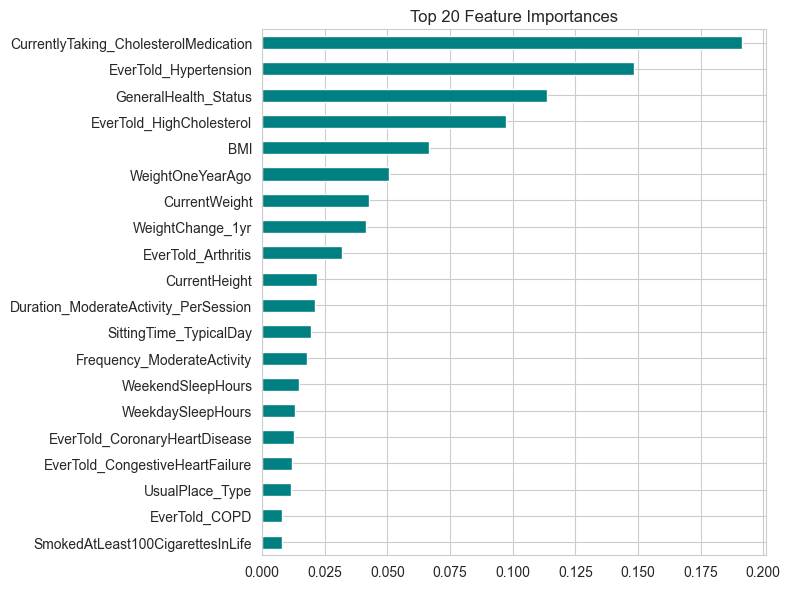

In [40]:
# Feature importance (tree models) or coefficients (logistic)
if best_model_name in ['Random Forest', 'XGBoost']:
    model = best_model.named_steps['model']
    importances = pd.Series(model.feature_importances_, index=features_keep).sort_values(ascending=False)
    print('Top 20 important features:')
    print(importances.head(20).to_string())
    importances.head(20).sort_values().plot(kind='barh', figsize=(8, 6), color='teal')
    plt.title('Top 20 Feature Importances')
    plt.tight_layout()
    plt.show()
else:
    model = best_model.named_steps['model']
    coef = pd.Series(model.coef_[0], index=features_keep)
    coef = coef.reindex(coef.abs().sort_values(ascending=False).index)
    print('Top 20 features by |coefficient|:')
    print(coef.head(20).to_string())
    coef.head(20).sort_values().plot(kind='barh', figsize=(8, 6), color='slateblue')
    plt.title('Top 20 Coefficients (Logistic Regression)')
    plt.tight_layout()
    plt.show()


In [48]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Example: Train Random Forest with class weights for imbalanced data


# Calculate class weights (inverse of class frequencies)

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = {k: v for k, v in zip(np.unique(y_train), class_weights)}
print("Class weights:", class_weight_dict)

# Train Random Forest with class_weight
rf_weighted = RandomForestClassifier(
    n_estimators=300,
    max_depth=8,
    min_samples_leaf=5,
    class_weight=class_weight_dict,
    random_state=42
)
rf_weighted.fit(X_train, y_train)

# Evaluate
y_pred_weighted = rf_weighted.predict(X_test)
y_proba_weighted = rf_weighted.predict_proba(X_test)[:, 1]


print("Classification report (weighted RF):")
print(classification_report(y_test, y_pred_weighted))
print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred_weighted))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_weighted))

Class weights: {0: 0.5942921096810296, 1: 3.1513353115727}
Classification report (weighted RF):
              precision    recall  f1-score   support

           0       0.94      0.80      0.87      1787
           1       0.42      0.74      0.53       337

    accuracy                           0.79      2124
   macro avg       0.68      0.77      0.70      2124
weighted avg       0.86      0.79      0.81      2124

Confusion matrix:
[[1438  349]
 [  89  248]]
ROC-AUC: 0.8500130351250956
